In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os, csv, shapely, shapely.wkt, descartes, geopy, pickle, cloudpickle
from shapely.geometry import Point, Polygon
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import date, datetime, timedelta
from sklearn import preprocessing
from sklearn import metrics as skm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from fairlearn.metrics import MetricFrame
from fairlearn.reductions import BoundedGroupLoss, ExponentiatedGradient, AbsoluteLoss, GridSearch
from itertools import repeat
from sklearn.model_selection import KFold

# pd.set_option('display.max_rows', 10)
# sns.set()
# sns.color_palette("ch:s=.25,rot=-.25")
np.set_printoptions(suppress=True)
# pd.options.display.float_format = '{:.2f}'.format


Bad key "text.kerning_factor" on line 4 in
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [3]:
CITY = "C_"
save_dir = CITY + 'reg_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
if not os.path.exists(save_dir_preprocess):
    os.makedirs(save_dir_preprocess)

if not os.path.exists(save_dir_models):
    os.makedirs(save_dir_models)
    
if not os.path.exists(save_dir_forecast):
    os.makedirs(save_dir_forecast)

### 1. Data Preprocessing

In [4]:
df_census_tract = pd.read_csv("data_created/cells_census_tract.csv", index_col = 0)
df_public_transit_means = pd.read_csv("data_created/census_data/public_transit_means.csv", index_col = 0)
df_employment_rate = pd.read_csv("data_created/census_data/employment_rate.csv", index_col = 0)
df_2019_census_tract_hamilton = pd.read_csv("data_created/census_data/2019_census_tract_hamilton.csv", index_col = 0)

df_geo = df_census_tract[["cell_num", "geometry", "centroid", "tract_id", "stations"]]
df_census_tract = df_census_tract[["cell_num", "tract_id", "geometry", "stations", "capacity"]]

df_census_tract2 = df_2019_census_tract_hamilton.merge(df_public_transit_means, how = 'left', on = 'tract_id')
df_census_tract2 = df_census_tract2.merge(df_employment_rate, how = 'left', on = 'tract_id')

df_census_tract_final = df_census_tract.merge(df_census_tract2, how = 'left', on = 'tract_id')

df_census_tract_final.drop(columns = ["geometry"], inplace = True)
df_census_tract_final

,cell_num,tract_id,stations,capacity,total_population,total_housing_units,median_income,white_pct,black_pct,hispanic_pct,...,pct_car_truck_van_alone,pct_car_truck_van_carpooled,pct_public_transit,pct_walked,pct_bicycle,pct_other_means,pct_wfh,population_over_16,population_over_16_employed,population_over_16_unemployed
0,104,47065012100,0,0,6556,2922,59507.0,86.790726,8.221477,1.082977,...,88.3,6.0,0.0,0.7,0.0,0.0,5.1,2851,2780,71
1,105,47065012100,0,0,6556,2922,59507.0,86.790726,8.221477,1.082977,...,88.3,6.0,0.0,0.7,0.0,0.0,5.1,2851,2780,71
2,156,47065012100,0,0,6556,2922,59507.0,86.790726,8.221477,1.082977,...,88.3,6.0,0.0,0.7,0.0,0.0,5.1,2851,2780,71
3,157,47065012100,0,0,6556,2922,59507.0,86.790726,8.221477,1.082977,...,88.3,6.0,0.0,0.7,0.0,0.0,5.1,2851,2780,71
4,158,47065012100,0,0,6556,2922,59507.0,86.790726,8.221477,1.082977,...,88.3,6.0,0.0,0.7,0.0,0.0,5.1,2851,2780,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,4651,47065011201,0,0,12235,4993,91029.0,81.021659,8.622804,8.222313,...,80.4,8.2,0.0,2.0,0.0,0.0,9.4,5529,5315,214
1826,4652,47065011201,0,0,12235,4993,91029.0,81.021659,8.622804,8.222313,...,80.4,8.2,0.0,2.0,0.0,0.0,9.4,5529,5315,214
1827,4704,47065011201,0,0,12235,4993,91029.0,81.021659,8.622804,8.222313,...,80.4,8.2,0.0,2.0,0.0,0.0,9.4,5529,5315,214
1828,4705,47065011201,0,0,12235,4993,91029.0,81.021659,8.622804,8.222313,...,80.4,8.2,0.0,2.0,0.0,0.0,9.4,5529,5315,214


In [5]:
for row,col in df_geo.iterrows():
    df_geo.at[row, 'geometry'] = shapely.wkt.loads(df_geo.loc[row]['geometry'])
    df_geo.at[row, 'centroid'] = shapely.wkt.loads(df_geo.loc[row]['centroid'])
    
df_geo = gpd.GeoDataFrame(df_geo, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])

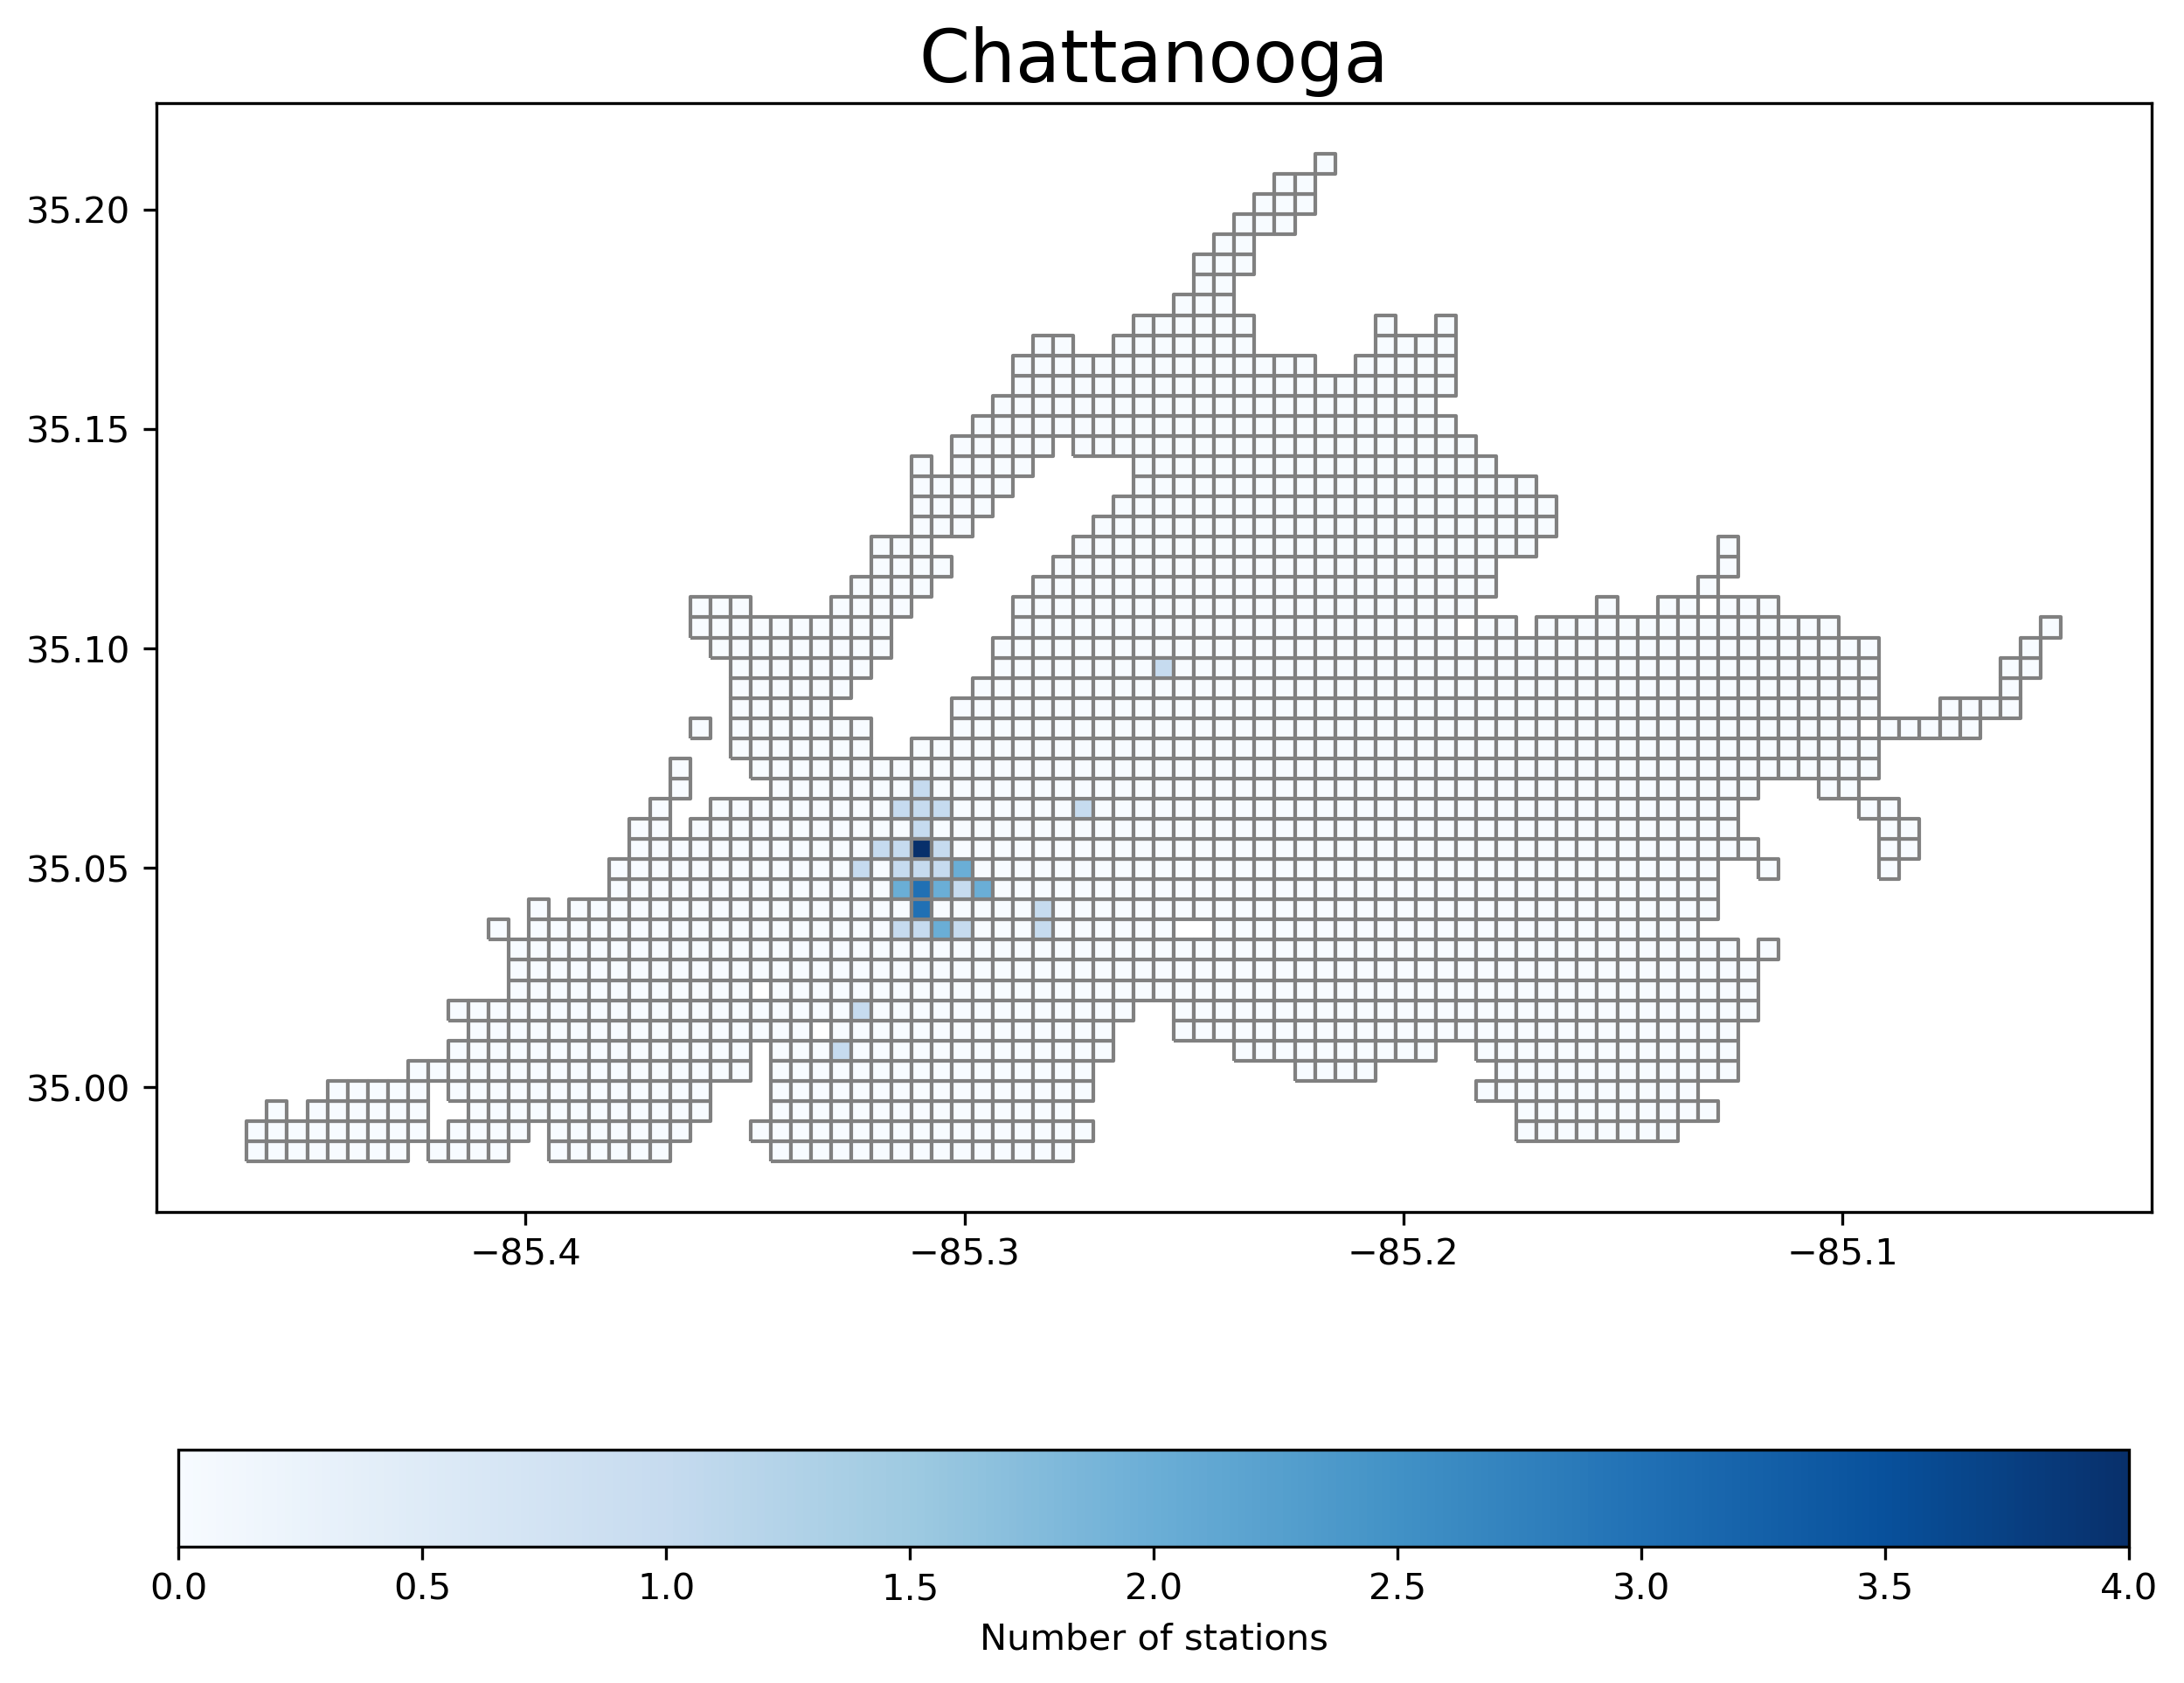

In [72]:
df_geo.to_csv(os.path.join(save_dir_forecast, CITY + "df_geo.csv"))

df_geo.plot(column="stations", cmap='Blues',edgecolor = "grey", figsize=(12, 8),  
                    legend = True, legend_kwds={'shrink': 0.8, 'label': "Number of stations",'orientation': "horizontal",})
# plt.title("Distribution of stations in Chattanooga", fontsize=20)
plt.title("Chattanooga", fontsize = 20)
plt.savefig(os.path.join(save_dir_preprocess, CITY+"stations_dist"), facecolor = 'w')
plt.savefig("chatt_stations")

In [7]:
df_walk_score = pd.read_csv("data_created/walk_score2.csv", index_col = 0).drop(columns = ['centroid', "walk_score_description", 
                                                                            "bike_description", "transit_description"])
df_walk_score.head()

,cell_num,walk_score,bike_score,transit_score,transit_summary
0,104,0.0,-1.0,-1.0,NaN
1,105,0.0,-1.0,-1.0,NaN
2,156,0.0,-1.0,-1.0,NaN
3,157,0.0,-1.0,-1.0,NaN
4,158,0.0,-1.0,-1.0,NaN


In [8]:
# extract parts from "nearby"

df_walk_score['nearby_bus'] = 0
df_walk_score['nearby_rail'] = 0
df_walk_score['nearby_other'] = 0
df_walk_score['nearby_routes'] = 0

for row,col in df_walk_score.iterrows():
    # if nearby == NaN
    if type(df_walk_score.loc[row]['transit_summary']) == float:
        df_walk_score.at[row, 'nearby_bus'] = 0
        df_walk_score.at[row, 'nearby_rail'] = 0
        df_walk_score.at[row, 'nearby_other'] = 0
        
    else:
        routes = df_walk_score.loc[row]['transit_summary']
        routes = routes.split(' ')
        nearby_routes = routes[0]
        nearby_bus = routes[3]
        nearby_rail = routes[5]
        nearby_other = routes[7]

        df_walk_score.at[row, 'nearby_bus'] = nearby_bus
        df_walk_score.at[row, 'nearby_rail'] = nearby_rail
        df_walk_score.at[row, 'nearby_other'] = nearby_other
        df_walk_score.at[row, 'nearby_routes'] = nearby_routes
        
df_walk_score.drop(columns = ["transit_summary"], inplace = True)
df_walk_score.reset_index(drop = True, inplace = True)

In [9]:
df_all = df_census_tract_final.merge(df_walk_score, on = 'cell_num')

# match fairST, replace negative value with 0
df_all[df_all < 0] = 0
df_all.to_csv(os.path.join(save_dir_forecast, CITY + "df_all.csv"))
df_all.head()

,cell_num,tract_id,stations,capacity,total_population,total_housing_units,median_income,white_pct,black_pct,hispanic_pct,...,population_over_16,population_over_16_employed,population_over_16_unemployed,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,104,47065012100,0,0,6556,2922,59507.0,86.790726,8.221477,1.082977,...,2851,2780,71,0.0,0.0,0.0,0,0,0,0
1,105,47065012100,0,0,6556,2922,59507.0,86.790726,8.221477,1.082977,...,2851,2780,71,0.0,0.0,0.0,0,0,0,0
2,156,47065012100,0,0,6556,2922,59507.0,86.790726,8.221477,1.082977,...,2851,2780,71,0.0,0.0,0.0,0,0,0,0
3,157,47065012100,0,0,6556,2922,59507.0,86.790726,8.221477,1.082977,...,2851,2780,71,0.0,0.0,0.0,0,0,0,0
4,158,47065012100,0,0,6556,2922,59507.0,86.790726,8.221477,1.082977,...,2851,2780,71,0.0,0.0,0.0,0,0,0,0


In [10]:
df_all_temp = df_all.copy()
df_all_temp["income_group"] = df_all_temp["median_income"].apply(lambda x: 1 if x > 50000 else 0)
df_all_temp[["cell_num", "income_group"]].to_csv(os.path.join(save_dir_fairst, "df_income.csv"))

In [11]:
# load outflow dataset
df_outflow_all = pd.read_csv("data_created/cell_outflow.csv", index_col = 0)
df_outflow = df_outflow_all[df_outflow_all.year.isin([2015, 2016, 2017, 2018, 2019])]
df_outflow
# df_outflow.to_csv("df_outflow.csv")

,cell_num,year,month,outflow
0,1617,2018,7,145
1,1617,2018,8,117
2,1617,2018,9,126
3,1617,2018,10,111
4,1617,2018,11,87
...,...,...,...,...
2563,2468,2019,8,526
2564,2468,2019,9,450
2565,2468,2019,10,397
2566,2468,2019,11,120


### complete missing date

In [12]:
# # Complete the missing dates & hours
# print("number of unique cells:", len(df_outflow.cell_num.unique()))
# unique_cell_ls = df_outflow.cell_num.unique()

# start_year, start_month, start_date = (2015, 1, 1)
# end_year, end_month, end_date = (2019, 12, 31)

In [13]:
# # cell2outflow = {}
# outflow_complete = pd.DataFrame()

# for i in np.arange(len(unique_cell_ls)):
#     curr_cell = unique_cell_ls[i]
#     # get outflow of that cell
#     temp = df_outflow[df_outflow.cell_num == curr_cell]
#     temp.reset_index(inplace = True, drop = True)
#     # create empty df for all time range
#     date_range = pd.date_range(date(start_year, start_month, start_date), date(end_year, end_month, end_date) + timedelta(days=1), freq='m')
#     df_outflow_monthly = pd.DataFrame({'Date': date_range})
#     df_outflow_monthly['year'] = pd.DatetimeIndex(df_outflow_monthly['Date']).year
#     df_outflow_monthly['month'] = pd.DatetimeIndex(df_outflow_monthly['Date']).month
#     df_outflow_monthly["cell_num"] = [curr_cell]*len(df_outflow_monthly)

#     df_outflow_monthly.drop(columns = ['Date'], inplace = True)

#     outflow_temp = df_outflow_monthly.merge(temp, how='left', on = ["year", "month"]).fillna(0)
#     outflow_temp.drop(columns = ["cell_num_y"], inplace = True)
#     outflow_temp.rename(columns = {"cell_num_x": "cell_num"}, inplace = True)
#     outflow_temp.outflow = outflow_temp.outflow.astype(int)
#     outflow_temp.cell_num = outflow_temp.cell_num.astype(int)
#     if i == 0:
#         outflow_complete = outflow_temp

#     else:
#         outflow_complete = outflow_complete.append(outflow_temp, ignore_index=True)
#     # create dict to record cell -> outflow df
#     # cell2outflow[curr_cell] = outflow_temp

# # Example output
# # cell2outflow[unique_cell_ls[0]]
# outflow_complete = outflow_complete[["cell_num", "year", "month", "outflow"]]
# outflow_complete

In [14]:
outflow_complete = df_outflow

In [15]:
# merge outflow
df = outflow_complete.merge(df_all, on = 'cell_num', how = 'left')
# df = outflow_complete.merge(df_all, on = 'cell_num', how = 'left')
df

,cell_num,year,month,outflow,tract_id,stations,capacity,total_population,total_housing_units,median_income,...,population_over_16,population_over_16_employed,population_over_16_unemployed,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,1617,2018,7,145,47065001800,1,19,2546,1383,53115.0,...,1385,1349,36,54.0,45.0,25.0,1,0,0,1
1,1617,2018,8,117,47065001800,1,19,2546,1383,53115.0,...,1385,1349,36,54.0,45.0,25.0,1,0,0,1
2,1617,2018,9,126,47065001800,1,19,2546,1383,53115.0,...,1385,1349,36,54.0,45.0,25.0,1,0,0,1
3,1617,2018,10,111,47065001800,1,19,2546,1383,53115.0,...,1385,1349,36,54.0,45.0,25.0,1,0,0,1
4,1617,2018,11,87,47065001800,1,19,2546,1383,53115.0,...,1385,1349,36,54.0,45.0,25.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,2468,2019,8,526,47065011411,1,25,4262,1985,45459.0,...,2199,2072,127,10.0,70.0,0.0,0,0,0,0
1447,2468,2019,9,450,47065011411,1,25,4262,1985,45459.0,...,2199,2072,127,10.0,70.0,0.0,0,0,0,0
1448,2468,2019,10,397,47065011411,1,25,4262,1985,45459.0,...,2199,2072,127,10.0,70.0,0.0,0,0,0,0
1449,2468,2019,11,120,47065011411,1,25,4262,1985,45459.0,...,2199,2072,127,10.0,70.0,0.0,0,0,0,0


In [16]:
# weather dataset
df_weather = pd.read_csv("data_created/chattanooga_weather.csv")
# get year and month
for index, row in df_weather.iterrows():
    data = [row.Date.astype(int)]
    df_weather.loc[index, "year"] = [datetime.strptime(str(s), '%Y%m') for s in data][0].year
    df_weather.loc[index, "month"] = [datetime.strptime(str(s), '%Y%m') for s in data][0].month
    
df_weather.drop(columns = ["Date"], inplace=True)
df_weather.rename(columns = {"Value": "weather", }, inplace=True)
df_weather.to_csv(os.path.join(save_dir_forecast, CITY + "df_weather.csv"))

In [17]:
# merge with dataset
df = df.merge(df_weather, on = ["year", "month"])
df.head()

,cell_num,year,month,outflow,tract_id,stations,capacity,total_population,total_housing_units,median_income,...,population_over_16_employed,population_over_16_unemployed,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,weather
0,1617,2018,7,145,47065001800,1,19,2546,1383,53115.0,...,1349,36,54.0,45.0,25.0,1,0,0,1,81.2
1,1671,2018,7,265,47065001900,1,19,3730,1983,23661.0,...,1170,373,48.0,58.0,25.0,1,0,0,1,81.2
2,1678,2018,7,190,47065001600,1,19,2632,1989,12906.0,...,542,188,34.0,48.0,36.0,10,0,0,10,81.2
3,1731,2018,7,252,47065001600,1,15,2632,1989,12906.0,...,542,188,37.0,44.0,43.0,10,0,0,10,81.2
4,1779,2018,7,146,47065002000,1,15,1484,854,64352.0,...,789,21,70.0,89.0,42.0,8,0,0,8,81.2


In [18]:
# select feature
df.drop(columns = ['white_pct', 'black_pct', 'hispanic_pct', 'population_over_16', 
                   'pct_total_car_truck_van', "pct_bicycle", "tract_id"], inplace = True)

In [19]:
# calculate normalized pop: for RFG
cell_num_ls = df[df.year == 2019].cell_num.unique()
normalized_pop_df = pd.DataFrame(0, columns = ['pop'] , index = cell_num_ls)
        
for cell in cell_num_ls:
    pop = df[df.year == 2019][df[df.year == 2019].cell_num == cell]['total_population'].reset_index(drop=True)[0]
    normalized_pop_df.loc[cell, 'pop'] = pop
    
normalized_pop_df["normalized_pop"] = normalized_pop_df["pop"] / normalized_pop_df["pop"].sum()
normalized_pop_df.to_csv(os.path.join(save_dir_fairst, "normalized_pop_df.csv"))

## 2. Fairness

In [20]:
print(df["median_income"].describe())
# training set
df["income_group"] = 0
for row, col in df.iterrows():
    if df.loc[row]["median_income"] > 50000:
        df.at[row, "income_group"] = 1
        
df[["cell_num", "income_group"]].to_csv(os.path.join(save_dir_fairst, "df_income.csv"))
df.drop(columns = ["median_income"], inplace = True)

count     1451.000000
mean     47455.876637
std      19115.843680
min      12906.000000
25%      31204.000000
50%      49375.000000
75%      63699.000000
max      80400.000000
Name: median_income, dtype: float64


Text(0, 0.5, 'Count')

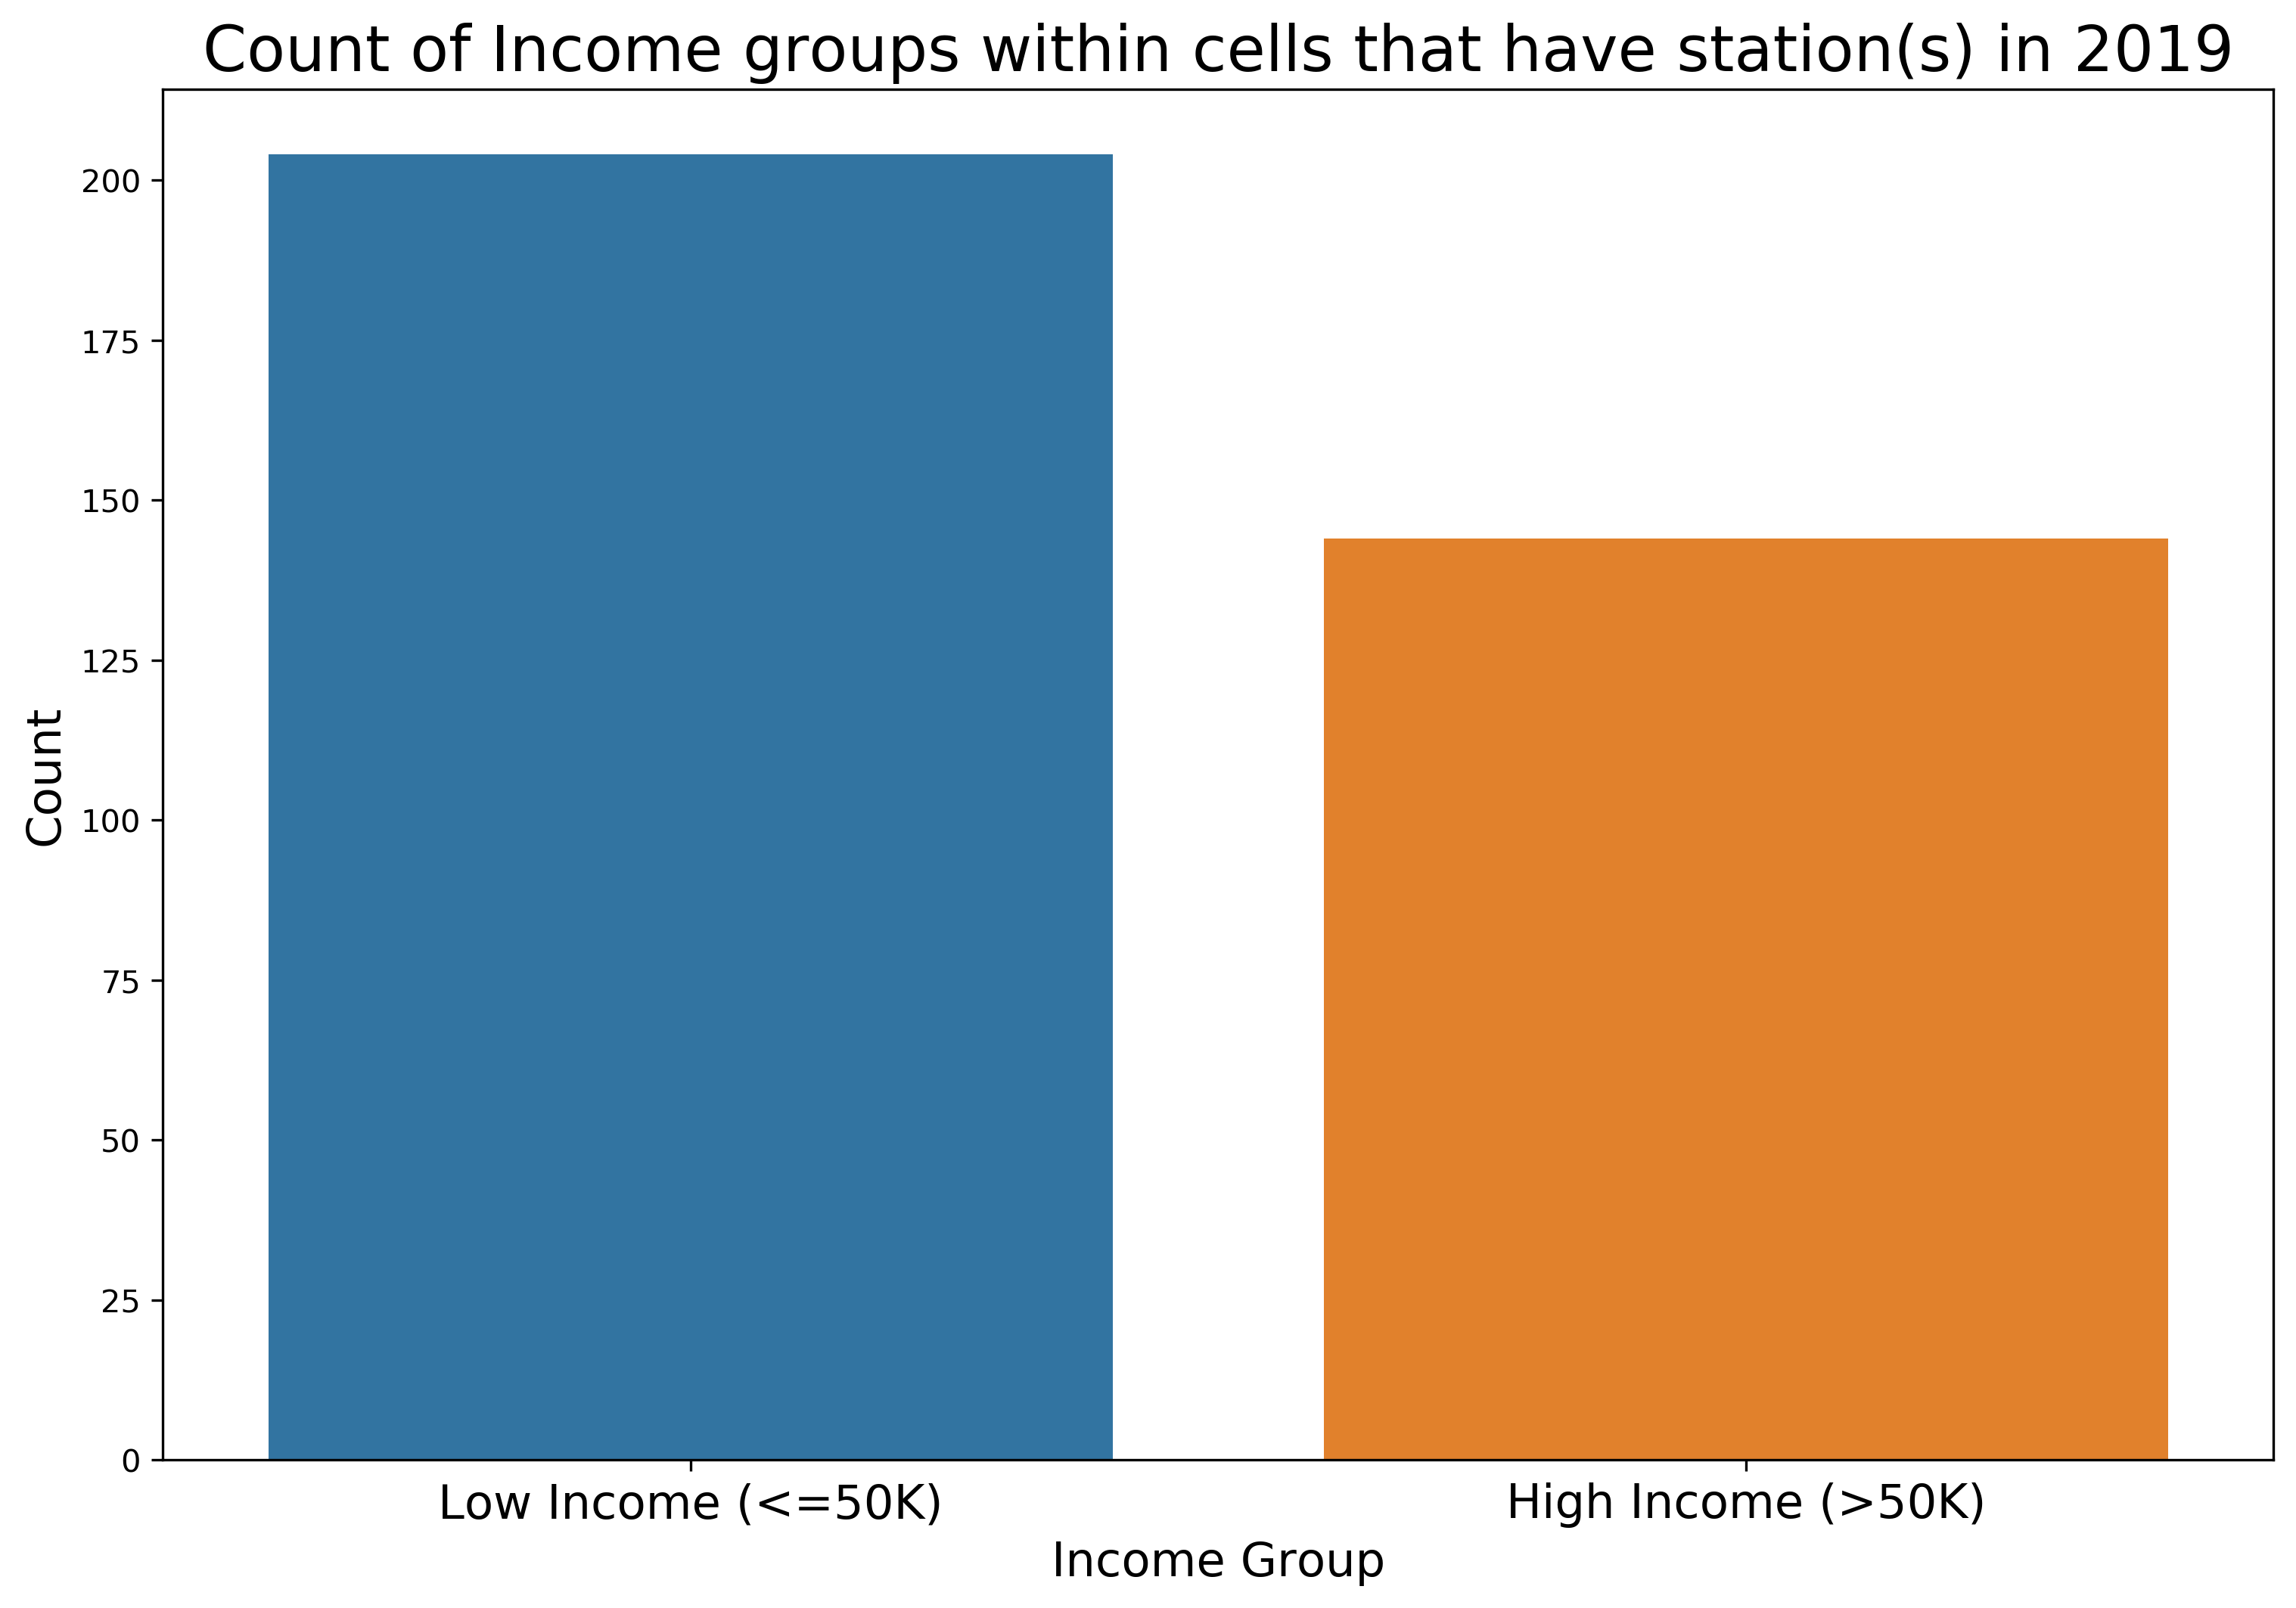

In [21]:
plt.figure(figsize = (12, 8))
sns.countplot(df[df.year == 2019]["income_group"])
plt.title("Count of Income groups within cells that have station(s) in 2019", fontsize = 20)
plt.xticks([0, 1], ["Low Income (<=50K)", "High Income (>50K)"], fontsize = 15)
plt.xlabel("Income Group", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
# plt.savefig(os.path.join(save_dir_preprocess, CITY+"income_group_2019"))

### 2. train test split

### feature scaling

In [22]:
# # # outflow = df["outflow"].values.reshape(-1, 1) #returns a numpy array
# # feature scaling
# columns_new = list(df.columns)
# columns_new.remove("year")
# columns_new.remove("cell_num")
# columns_new.remove('income_group')

# min_max_scaler = preprocessing.MinMaxScaler()
# df_scaled = min_max_scaler.fit_transform(df.drop(columns = ['year', 'cell_num', 'income_group']))
# df_scaled = pd.DataFrame(df_scaled, columns = columns_new)

# df_scaled["year"] = df["year"]
# df_scaled["cell_num"] = df["cell_num"]
# df_scaled["outflow"] = df["outflow"]
# df_scaled["income_group"] = df["income_group"]
# # df_scaled["stations"] = df["stations"]

# # df_scaled.outflow = min_max_scaler.fit_transform(df_scaled.outflow.values.reshape(-1, 1))

In [23]:
# # feature scaling
# columns_new = list(df.columns)
# columns_new.remove("year")
# columns_new.remove("cell_num")
# columns_new.remove('income_group')
# # columns_new.remove('stations')

# # columns_new

In [24]:
# # # outflow = df["outflow"].values.reshape(-1, 1) #returns a numpy array

# min_max_scaler = preprocessing.MinMaxScaler()
# df_scaled = min_max_scaler.fit_transform(df.drop(columns = ['year', 'cell_num', 'income_group']))
# df_scaled = pd.DataFrame(df_scaled, columns = columns_new)

# df_scaled["year"] = df["year"]
# df_scaled["cell_num"] = df["cell_num"]
# df_scaled["outflow"] = df["outflow"]
# df_scaled["income_group"] = df["income_group"]
# # df_scaled["stations"] = df["stations"]

# df_scaled
# df_scaled.outflow = min_max_scaler.fit_transform(df_scaled.outflow.values.reshape(-1, 1))

Text(0, 0.5, 'sum of outflow')

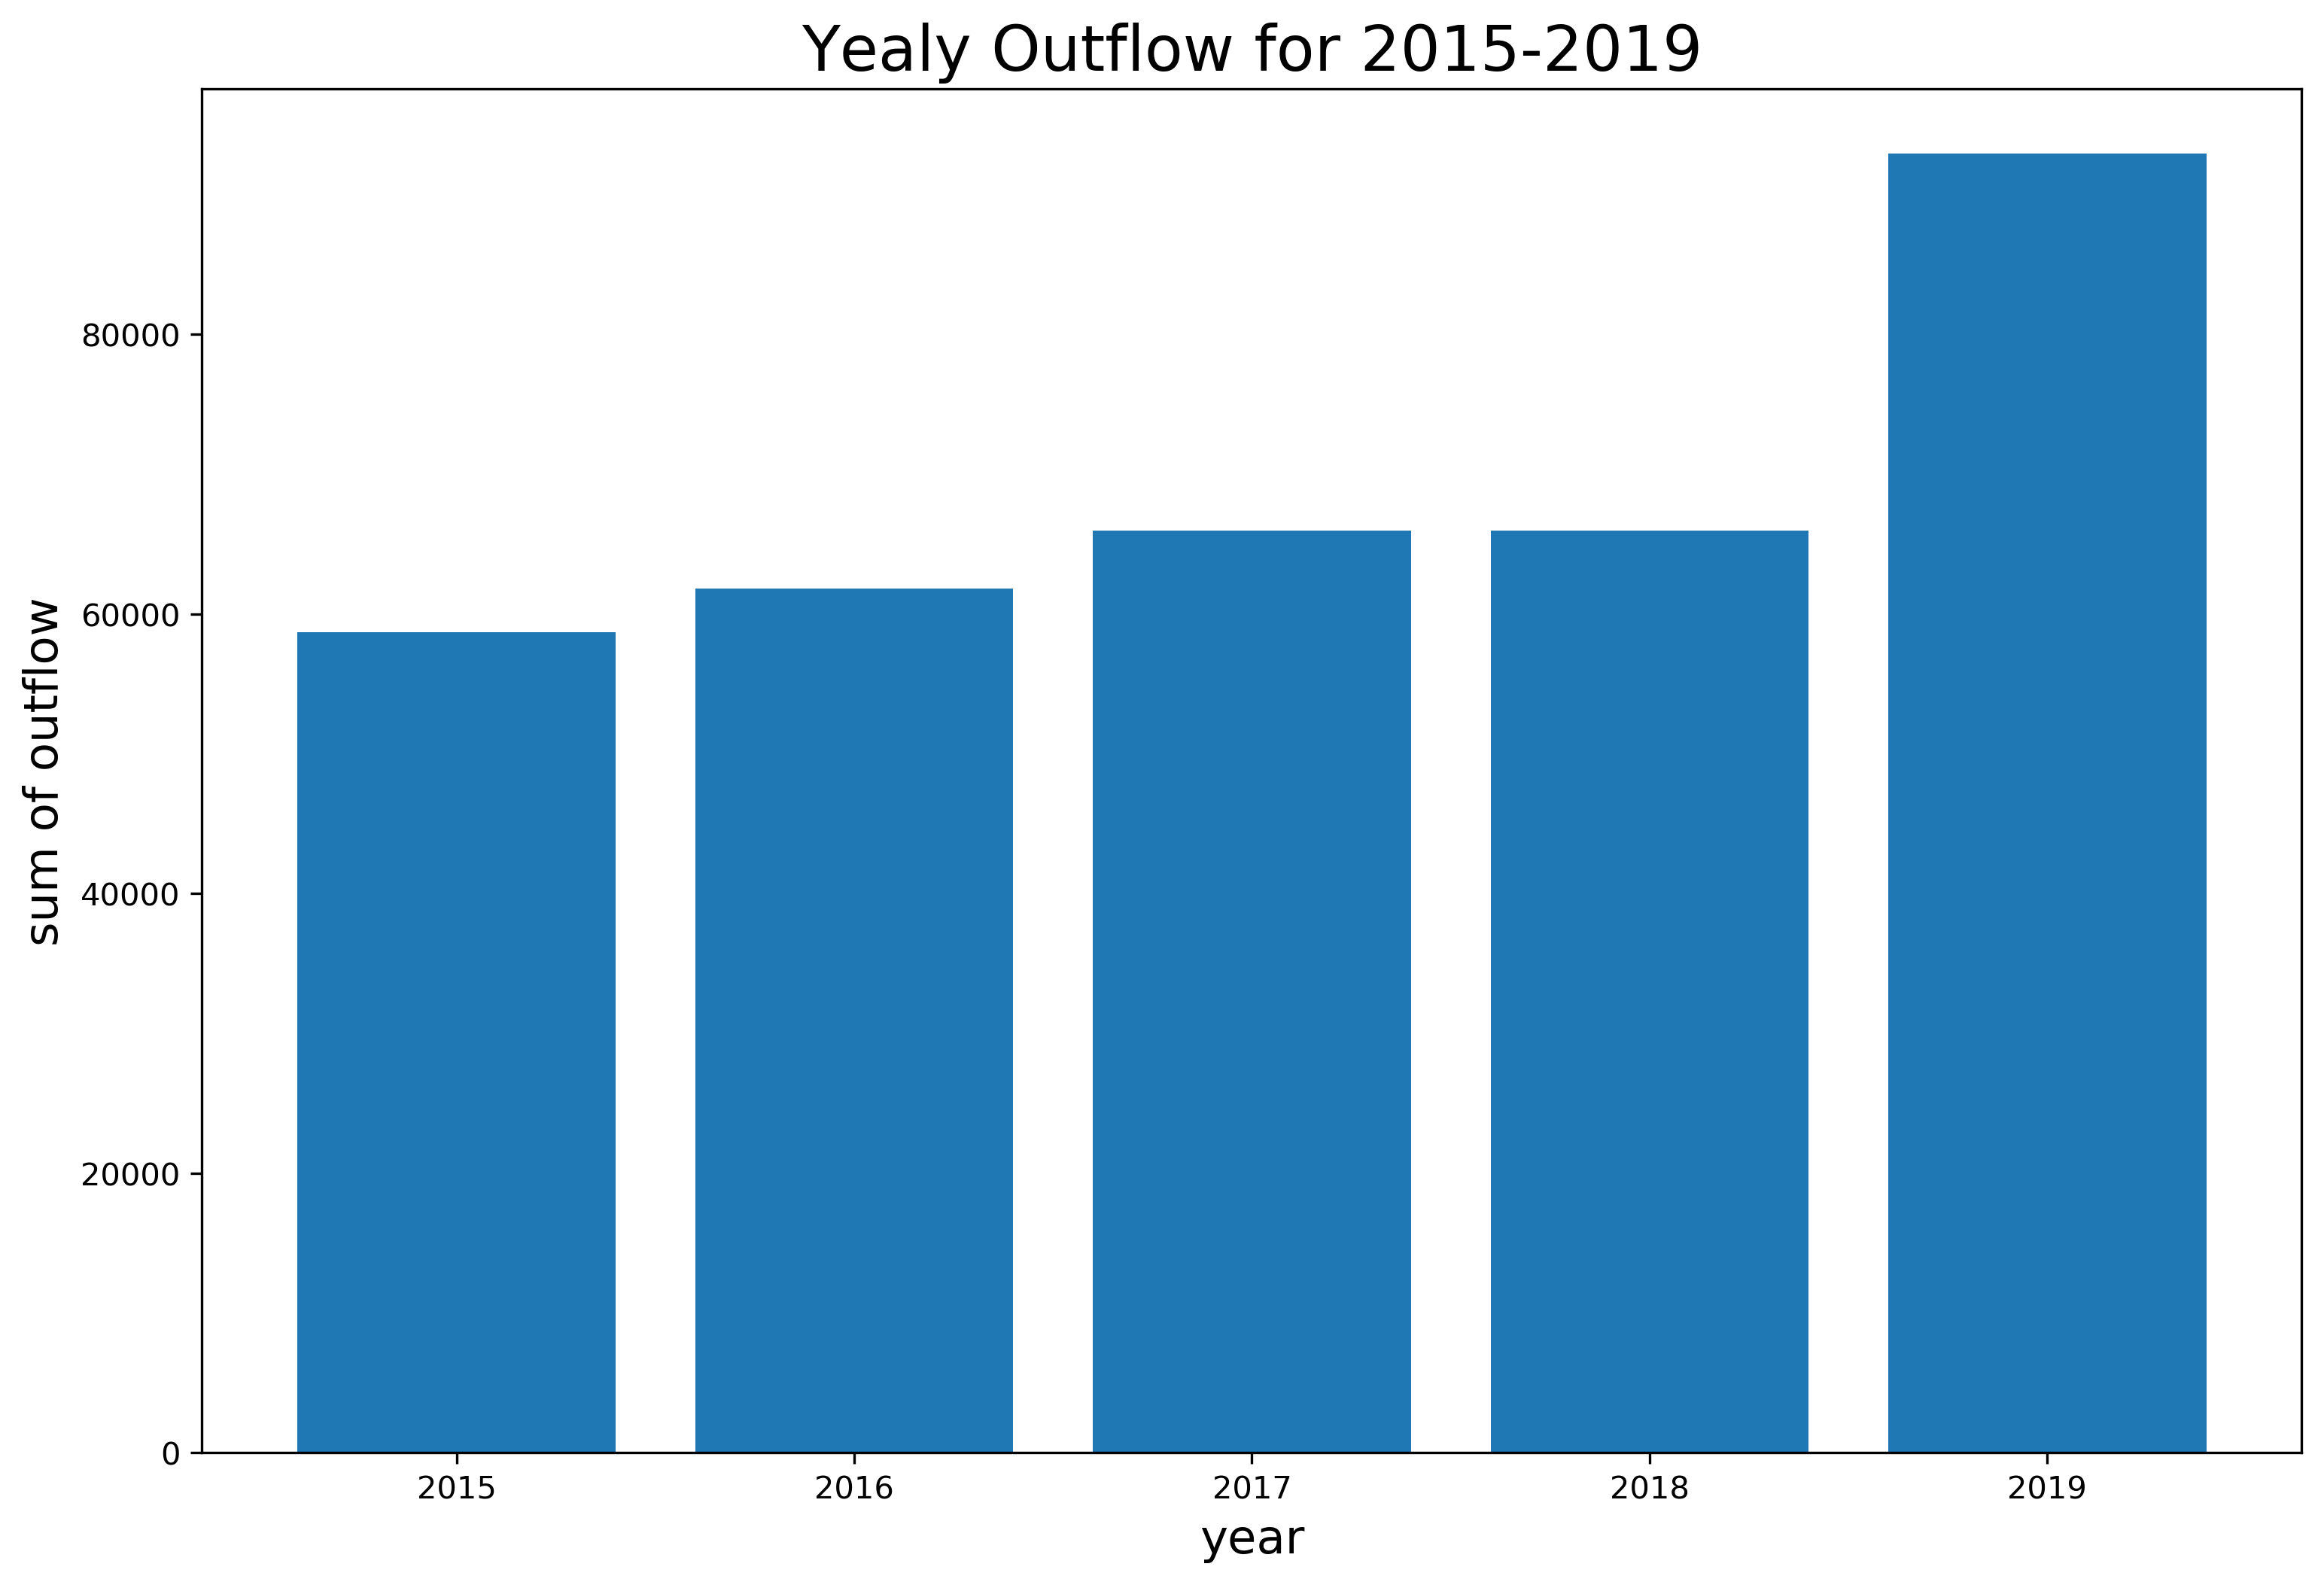

In [25]:
plt.figure(figsize = (12, 8))
plt.bar(height = 'outflow', x = "year", data = df.groupby("year").sum().reset_index()[["year", "outflow"]])
plt.title("Yealy Outflow for 2015-2019", fontsize = 20)
plt.xlabel("year", fontsize = 15)
plt.ylabel("sum of outflow", fontsize = 15)
# plt.savefig(os.path.join(save_dir_preprocess, CITY+"yearly outflow"))

([<matplotlib.axis.XTick at 0x7f9c961da290>,
 <a list of 12 Text xticklabel objects>)

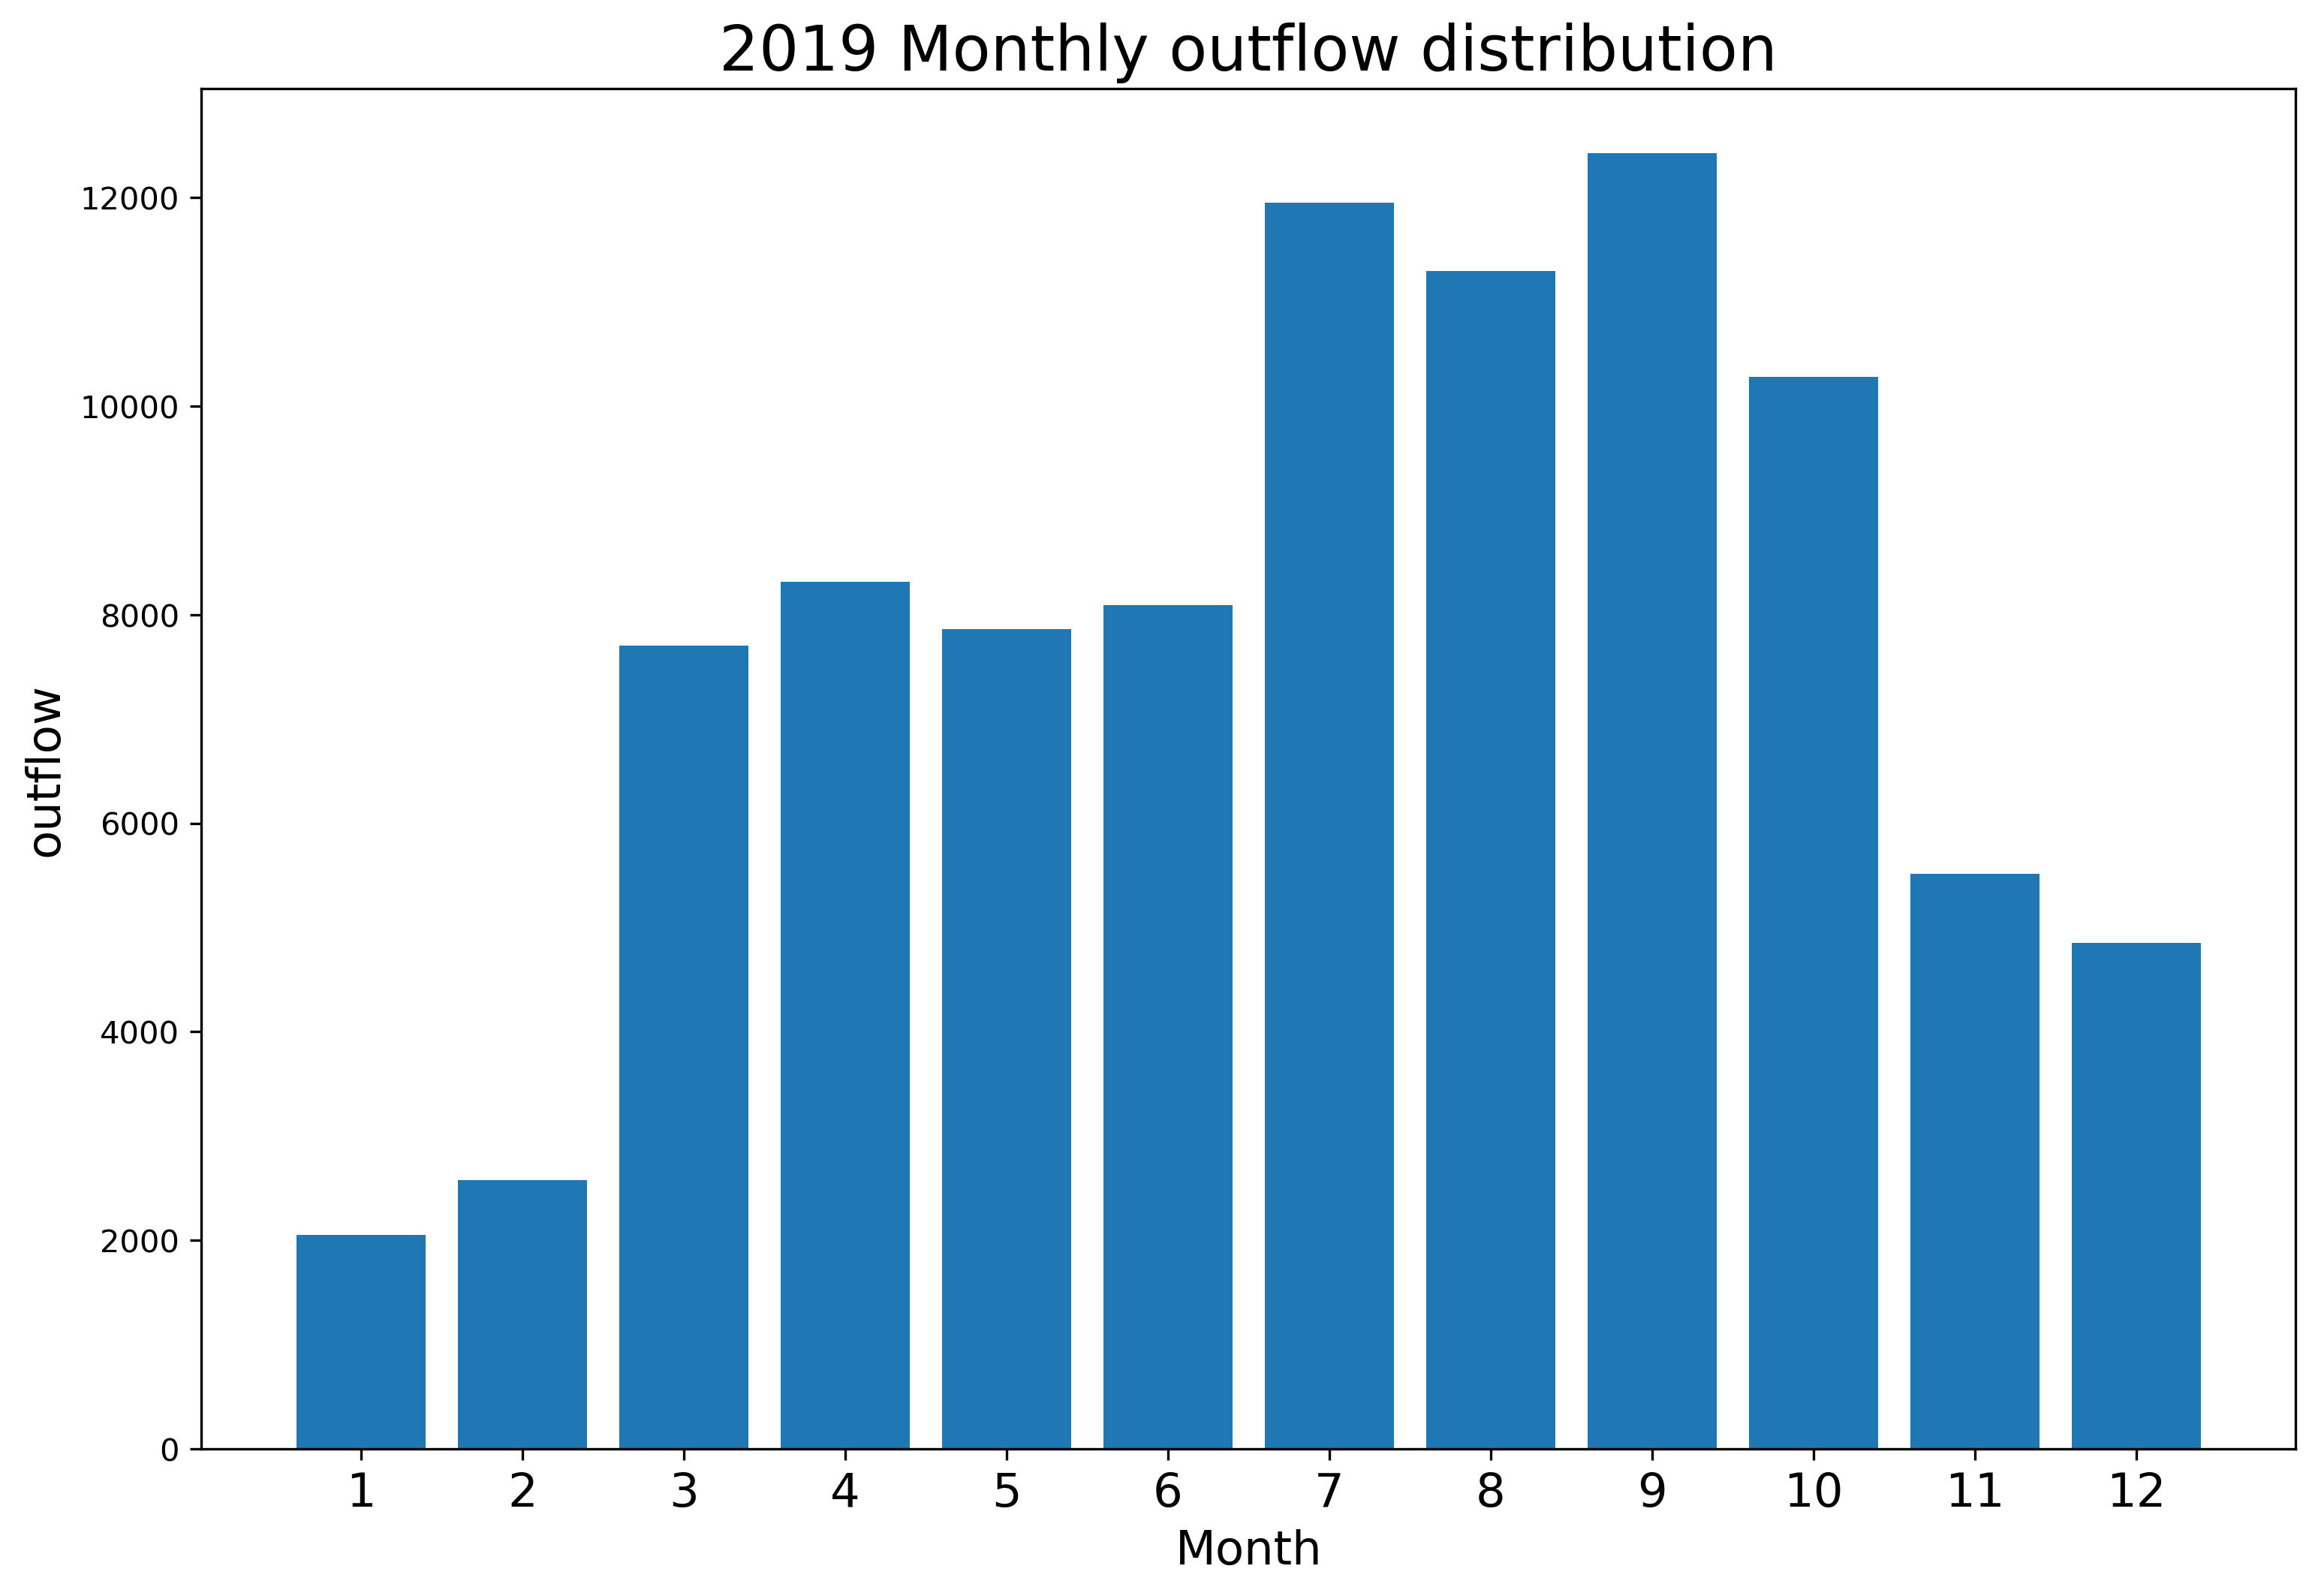

In [26]:
plt.figure(figsize = (12, 8))
plt.bar(x = df[df.year == 2019].groupby("month").sum()["outflow"].index , height = df[df.year == 2019].groupby("month").sum()["outflow"].values)
plt.title("2019 Monthly outflow distribution", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("outflow", fontsize = 15)
plt.xticks(df[df.year == 2019].groupby("month").sum()["outflow"].index, fontsize = 15)
# plt.savefig(os.path.join(save_dir_preprocess, CITY+"2019_monthly_outflow"))

In [27]:
# Train Test split
df_1518 = df[df["year"].isin([2015, 2016, 2017, 2018])] # 1032
df_19 = df[df["year"].isin([2019]) & ~(df["month"] == 1)]

df_1518 = df_1518.drop(columns = ["year"])
df_19 = df_19.drop(columns = ["year"])

In [28]:
X_train = df_1518.drop(columns = ["outflow", "cell_num"])
X_test = df_19.drop(columns = ["outflow", "cell_num"])

y_train = df_1518["outflow"]
y_test = df_19["outflow"]

A_train = df_1518["income_group"]
A_test = df_19["income_group"]

y_test_cell_num = df_19[["cell_num", "income_group"]]
y_test_cell_num

,cell_num,income_group
196,1617,1
197,1671,0
198,1678,0
199,1731,0
200,1779,1
...,...,...
511,1989,0
512,2143,0
513,2144,0
514,2253,0


In [29]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()
A_train_copy = A_train.copy()
A_test_copy = A_test.copy()

In [30]:
# reset index
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
A_train.reset_index(drop = True, inplace = True)
A_test.reset_index(drop = True, inplace = True)

X_train.to_csv(os.path.join(save_dir_forecast, CITY + "X_train.csv"))

In [31]:
# RFG calculation
def rfg_calc(y_pred, y_gt, normalized_pop_df, y_test_cell_num):
    normalized_pop_df["cell_num"] = normalized_pop_df.index
    cell2group_df = y_test_cell_num.groupby("cell_num").mean().reset_index()
    cell2group_df["income_group"] = cell2group_df["income_group"].astype(int)
    cell_pop_df = normalized_pop_df.merge(cell2group_df, on = "cell_num")
    
    g1_pop = cell_pop_df[cell_pop_df["income_group"] == 1].normalized_pop.sum()
    g2_pop = cell_pop_df[cell_pop_df["income_group"] == 0].normalized_pop.sum()
    
    group_index = A_test.reset_index(drop = True)
    g1_pred = y_pred[group_index[group_index == 1].index]
    g2_pred = y_pred[group_index[group_index == 0].index]

    bike_g1 = g1_pred.sum() / len(y_pred)
    bike_g2 = g2_pred.sum()/ len(y_pred)
    # print("bike_g1 ", bike_g1)
    # print("bike_g2 ", bike_g2)
    
    return bike_g1 /g1_pop - bike_g2 /g2_pop

### 3 Fairness models

In [32]:
# summary df
model_summary = pd.DataFrame(0, columns = ["r2", "r2_diff", "mae", "mae_diff", "rfg"], 
                             index = ["random_forest", "exp_grad", "grid_search"])

# model_summary.to_csv(os.path.join(save_dir_models, "model_summary.csv"))

### 1) unmitigated random forest

In [33]:
# param_grid = { # 'bootstrap': [True, False],
#  'max_depth': [10, 20, 40, 50, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5],
#  'n_estimators': [10, 20, 40, 50, None]}

# # Create a based model
# rf = RandomForestRegressor(random_state = 42)
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose = 1, scoring = 'neg_mean_absolute_error') # r2 / neg_mean_absolute_error
# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# # save grid search model
# with open(os.path.join(save_dir_models, CITY+"random_forest_gs_best.csv"), 'w') as f:
#     for key in grid_search.best_params_.keys():
#         f.write("%s,%s\n"%(key, grid_search.best_params_[key]))
#     f.write("%s, %s\n"%("scoring", grid_search.scoring))

In [34]:
# print(grid_search.best_estimator_)
# print(grid_search.best_score_)
# grid_search_all_res = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["neg_mean_absolute_error"])], axis=1)
# grid_search_all_res.to_csv(os.path.join(save_dir_models, CITY+"random_forest_gs_all.csv"))

In [35]:
rf_best = pickle.load(open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb'))

R^2     0.957589
MAE    34.066584
dtype: object
------------------------------
                  R^2        MAE
income_group                    
0             0.89905  26.997473
1             0.96128  41.599026
R^2 diff: 0.06223
MAE diff: 14.60155
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c9610d2d0>],
      dtype=object)

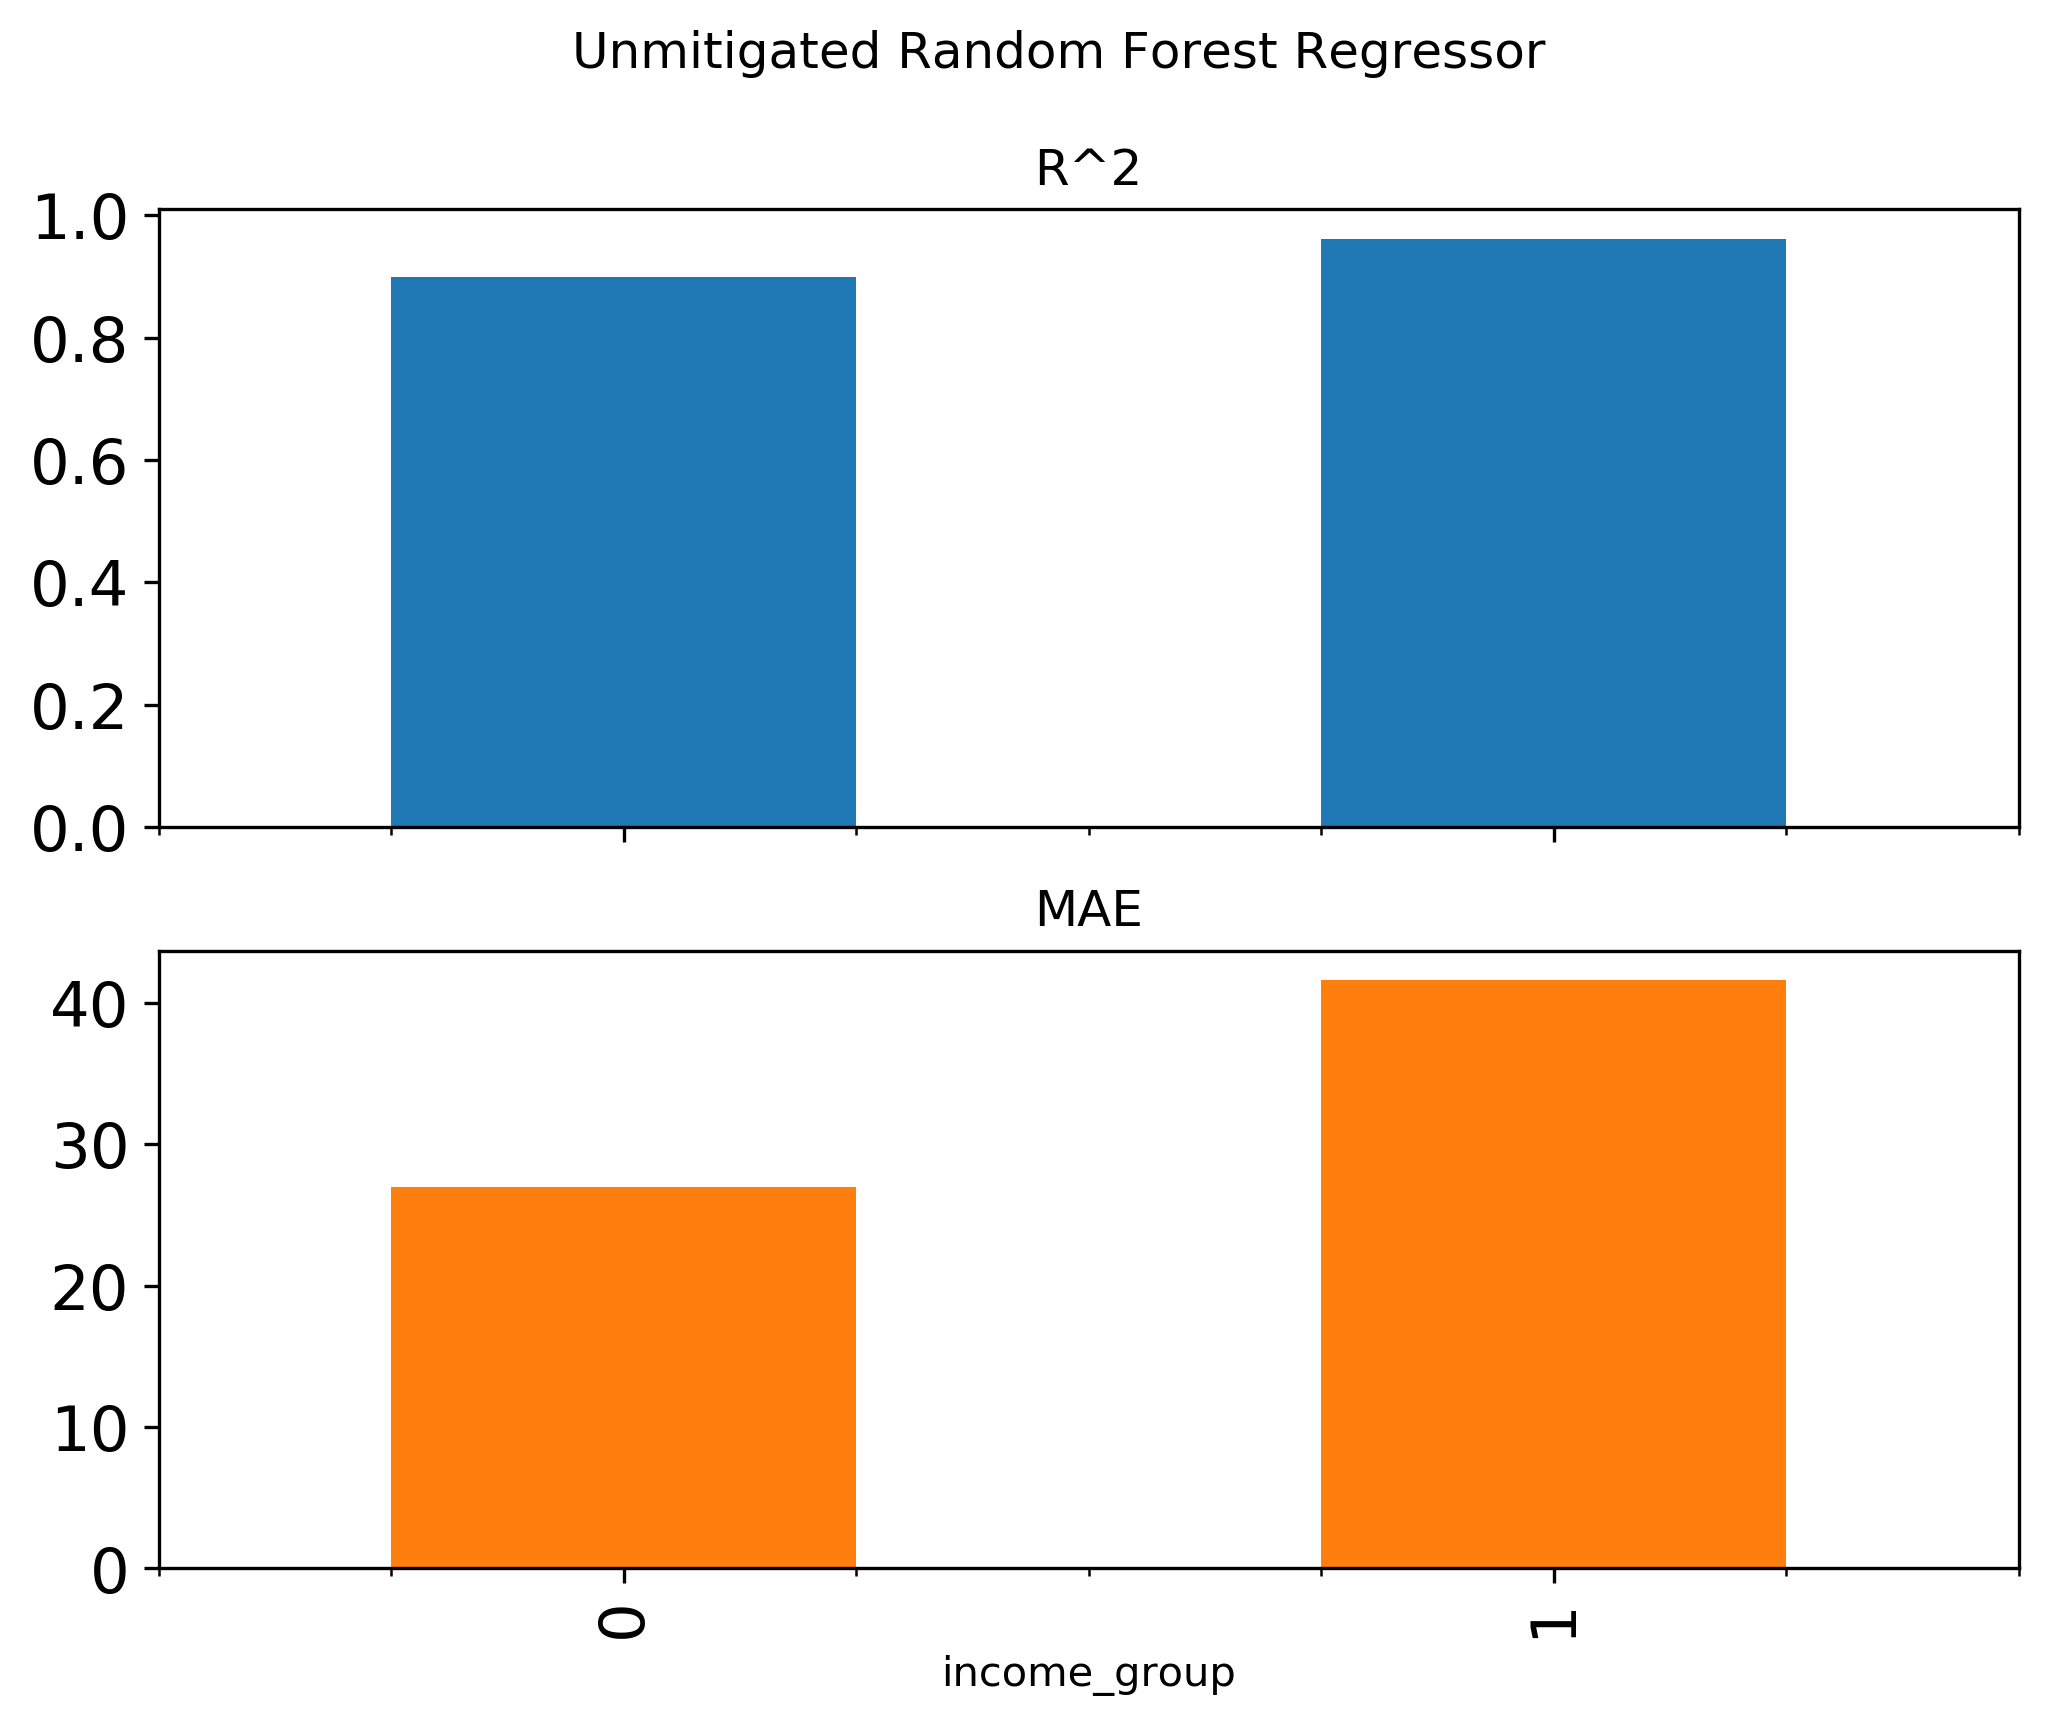

In [36]:
'''
Train set
'''

# rf_best = grid_search.best_estimator_
y_pred_rf_gs_train = rf_best.predict(X_train)

# Metric evaluation
metric_frame_rf_gs_train = MetricFrame(metric = 
                                    {"R^2": skm.r2_score,
                                    "MAE": skm.mean_absolute_error},
                                   sensitive_features = A_train,
                                   y_true = y_train,
                                   y_pred = y_pred_rf_gs_train)
print(metric_frame_rf_gs_train.overall)
print("-"*30)
print(metric_frame_rf_gs_train.by_group)
print("R^2 diff:", "{:.5f}".format(metric_frame_rf_gs_train.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_rf_gs_train.difference()["MAE"]))
print("-"*30)
# print("RFG:", rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num))

# # save model
# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs_train.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Unmitigated Random Forest Regressor', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"random_forest_metric"))

R^2     0.823572
MAE    89.202989
dtype: object
------------------------------
                   R^2         MAE
income_group                      
0              0.55077   75.351672
1             0.848229  108.930623
R^2 diff: 0.29746
MAE diff: 33.57895
------------------------------
RFG: 347.4573454940139


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c9604e750>],
      dtype=object)

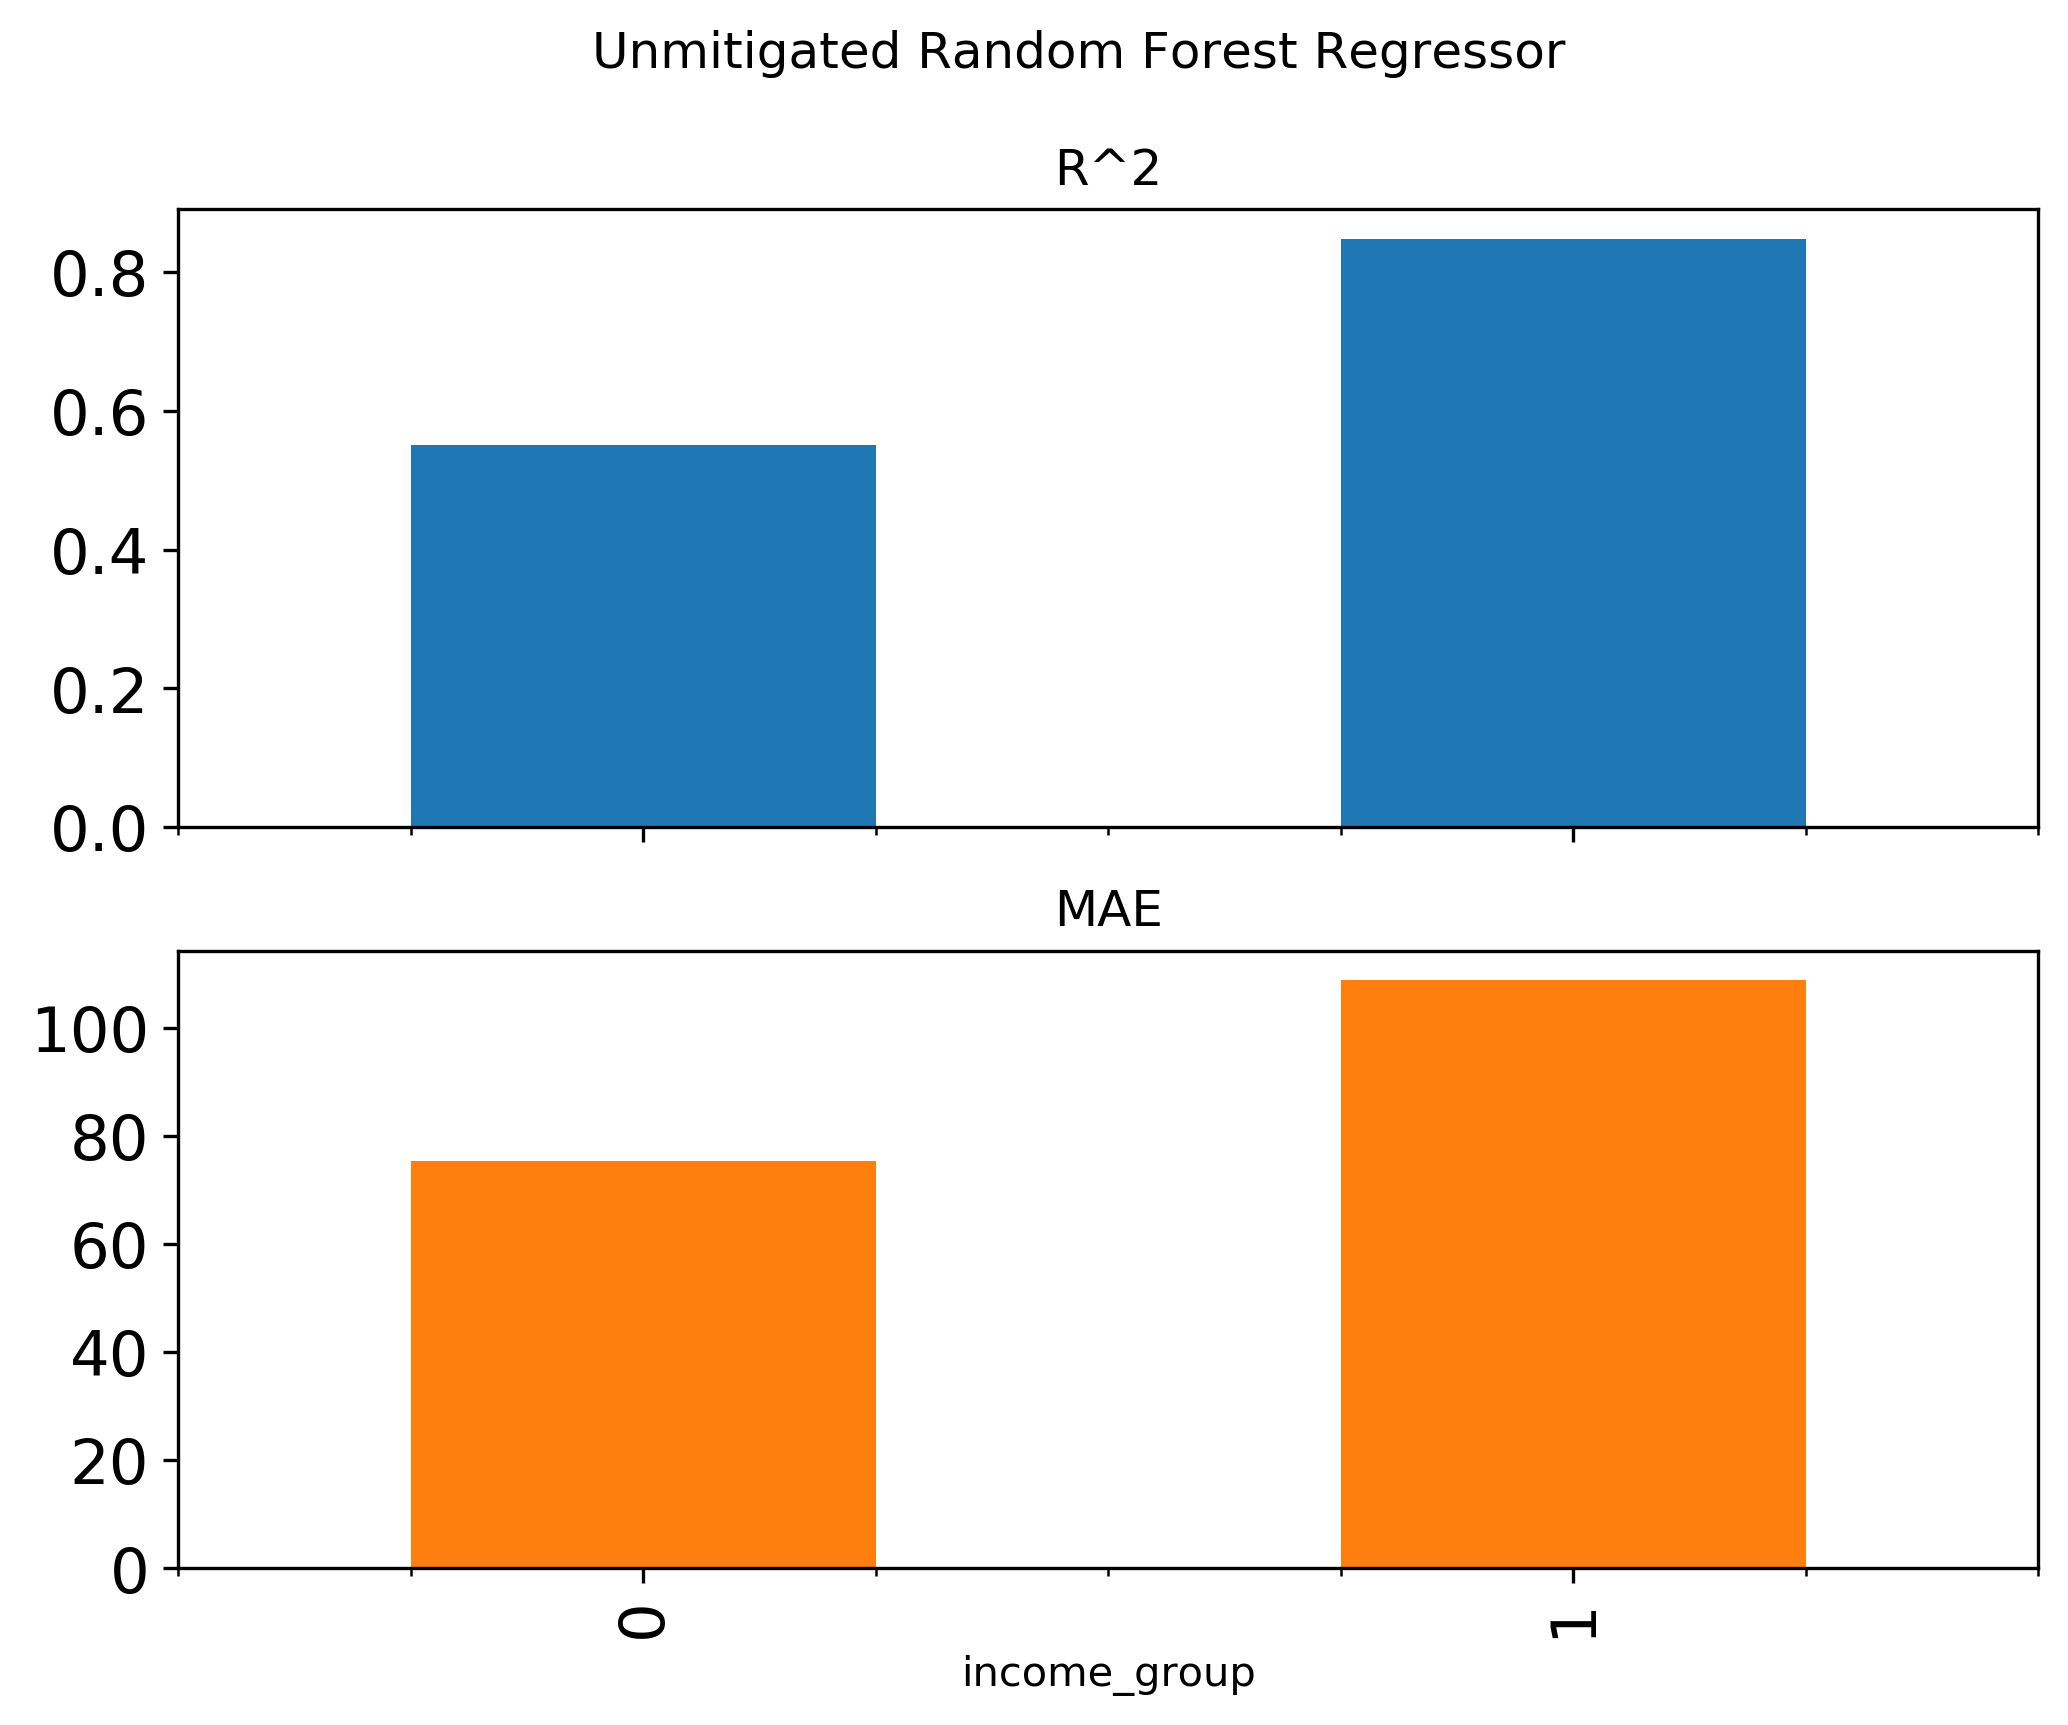

In [37]:
'''
Test set
'''

# rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf_gs = rf_best.predict(X_test)

# Metric evaluation
metric_frame_rf_gs = MetricFrame(metric = 
                                    {"R^2": skm.r2_score,
                                    "MAE": skm.mean_absolute_error},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_rf_gs)
print(metric_frame_rf_gs.overall)
print("-"*30)
print(metric_frame_rf_gs.by_group)
print("R^2 diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["MAE"]))
print("-"*30)
print("RFG:", rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num))

# save model
model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Unmitigated Random Forest Regressor', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"random_forest_metric"))

In [38]:
# # save model
# Pkl_Filename = "random_forest.pkl"  
# with open(os.path.join(save_dir_forecast, CITY+Pkl_Filename), 'wb') as file:  
#     pickle.dump(rf_best, file)

### 2) Exponentiated Gradient (constraint: BGL)

In [39]:
# # diff_bound_l = np.arange(0, 100000, 2000)/10000000
# # diff_bound_l = diff_bound_l[1:]
# # diff_bound_l = [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5]

# diff_bound_l = np.linspace(0, 5, 50)
# diff_bound_l

In [40]:
# # cross validation for EG
# # implement K-fold cross validation

# exp_grad_result = pd.DataFrame({"diff_bound": diff_bound_l})

# for i in range(len(diff_bound_l)):
#     cv_r2_ls = []
#     cv_mae_ls = []
#     cv_r2_diff_ls = []
#     cv_mae_diff_ls = []
    
#     print(i)
#     diff_bound = diff_bound_l[i]
    
#     # train-valid split
#     kfold = KFold(3, shuffle = True, random_state = 42)
#     for train, valid in kfold.split(X_train):
#         # print("CV")
#         X_train_exp = X_train.loc[train]
#         y_train_exp = y_train.loc[train]
#         A_train_exp = A_train.loc[train]

#         X_valid = X_train.loc[valid]
#         y_valid = y_train.loc[valid]
#         A_valid = A_train.loc[valid]

#         # avoid failure of optimization
#         try:
#             # train
#             constraint = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound)
#             exp_grad = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
#             exp_grad.fit(X_train_exp, y_train_exp, sensitive_features = A_train_exp)
#             y_valid_pred = exp_grad.predict(X_valid, random_state = 42)

#             # performance validation #
#             metric_frame_eg_cv = MetricFrame(metric = {"R^2": skm.r2_score,  "MAE": skm.mean_absolute_error},
#                                             sensitive_features = A_valid, y_true = y_valid, y_pred = y_valid_pred)

#             cv_r2_ls.append(skm.r2_score(y_valid, y_valid_pred))
#             cv_mae_ls.append(skm.mean_absolute_error(y_valid, y_valid_pred))
#             cv_r2_diff_ls.append(metric_frame_eg_cv.difference()["R^2"])
#             cv_mae_diff_ls.append(metric_frame_eg_cv.difference()["MAE"])

#         except:
#             cv_r2_ls.append(np.nan)
#             cv_mae_ls.append(np.nan)
#             cv_r2_diff_ls.append(np.nan)
#             cv_mae_diff_ls.append(np.nan)

#     exp_grad_result.loc[i, "cv_avg_r2"] = np.nanmean(np.array(cv_r2_ls))
#     exp_grad_result.loc[i, "cv_avg_r2_diff"] = np.nanmean(np.array(cv_r2_diff_ls))
#     exp_grad_result.loc[i, "cv_avg_mae"] = np.nanmean(np.array(cv_mae_ls))
#     exp_grad_result.loc[i, "cv_avg_mae_diff"] = np.nanmean(np.array(cv_mae_diff_ls))

#     # exp_grad_result.to_csv(os.path.join(save_dir_models, CITY+"exp_grad_valid_res.csv"))

In [41]:
# best_eg_index = exp_grad_result[exp_grad_result.cv_avg_mae_diff == exp_grad_result.cv_avg_mae_diff.min()].index[0]
# print("best upper bound for BGL:", diff_bound_l[best_eg_index])

# # plot
# plt.figure(figsize = (25, 8))
# plt.plot(exp_grad_result.diff_bound, exp_grad_result.cv_avg_mae_diff)
# plt.scatter(exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].diff_bound, exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, color = "red")
# # plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
# plt.xlabel("upper bound in BGL", fontsize = 15)
# plt.ylabel("MAE difference", fontsize = 15)
# plt.text(x = exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].diff_bound+0.0005, y = exp_grad_result.iloc[exp_grad_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, s = 'min', color = "red")
# plt.title("Cross Validation MAE diff for parameter 'upper_bound' \nin Bounded Group Loss for Exponentiated Gradient", fontsize = 18)
# plt.title("Exponentiated Gradient cross validation result: MAE difference vs. 'upper_bound' in BGL ", fontsize = 18)
# # plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_valid_res"))

In [42]:
# # predict on test set
# eg_best = ExponentiatedGradient(estimator = rf_best, 
#                               constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), 
#                               upper_bound = diff_bound_l[best_eg_index]))

# eg_best.fit(X_train, y_train, sensitive_features = A_train)
# y_pred_eg = eg_best.predict(X_test, random_state = 42)

In [43]:
# # save model
# Pkl_Filename = "exp_grad.pkl"  
# with open(os.path.join(save_dir_forecast, CITY+Pkl_Filename), 'wb') as file:  
#     cloudpickle.dump(eg_best, file)

In [44]:
eg_best = cloudpickle.load(open(os.path.join(save_dir_models, CITY + "exp_grad.pkl"), 'rb'))
y_pred_eg = eg_best.predict(X_test, random_state = 42)

In [45]:
eg_best.predict(X_train, random_state = 42)

array([131.99833333, 238.80333333, 211.38380952, ..., 109.29416667,
        72.19916667, 342.93333333])

R^2     0.959964
MAE    32.578939
dtype: object
------------------------------
                   R^2        MAE
income_group                     
0             0.901769  26.349729
1             0.963796  39.216431

R^2 diff: 0.06202759497191179
MAE diff: 12.866701468367364
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c81f00610>],
      dtype=object)

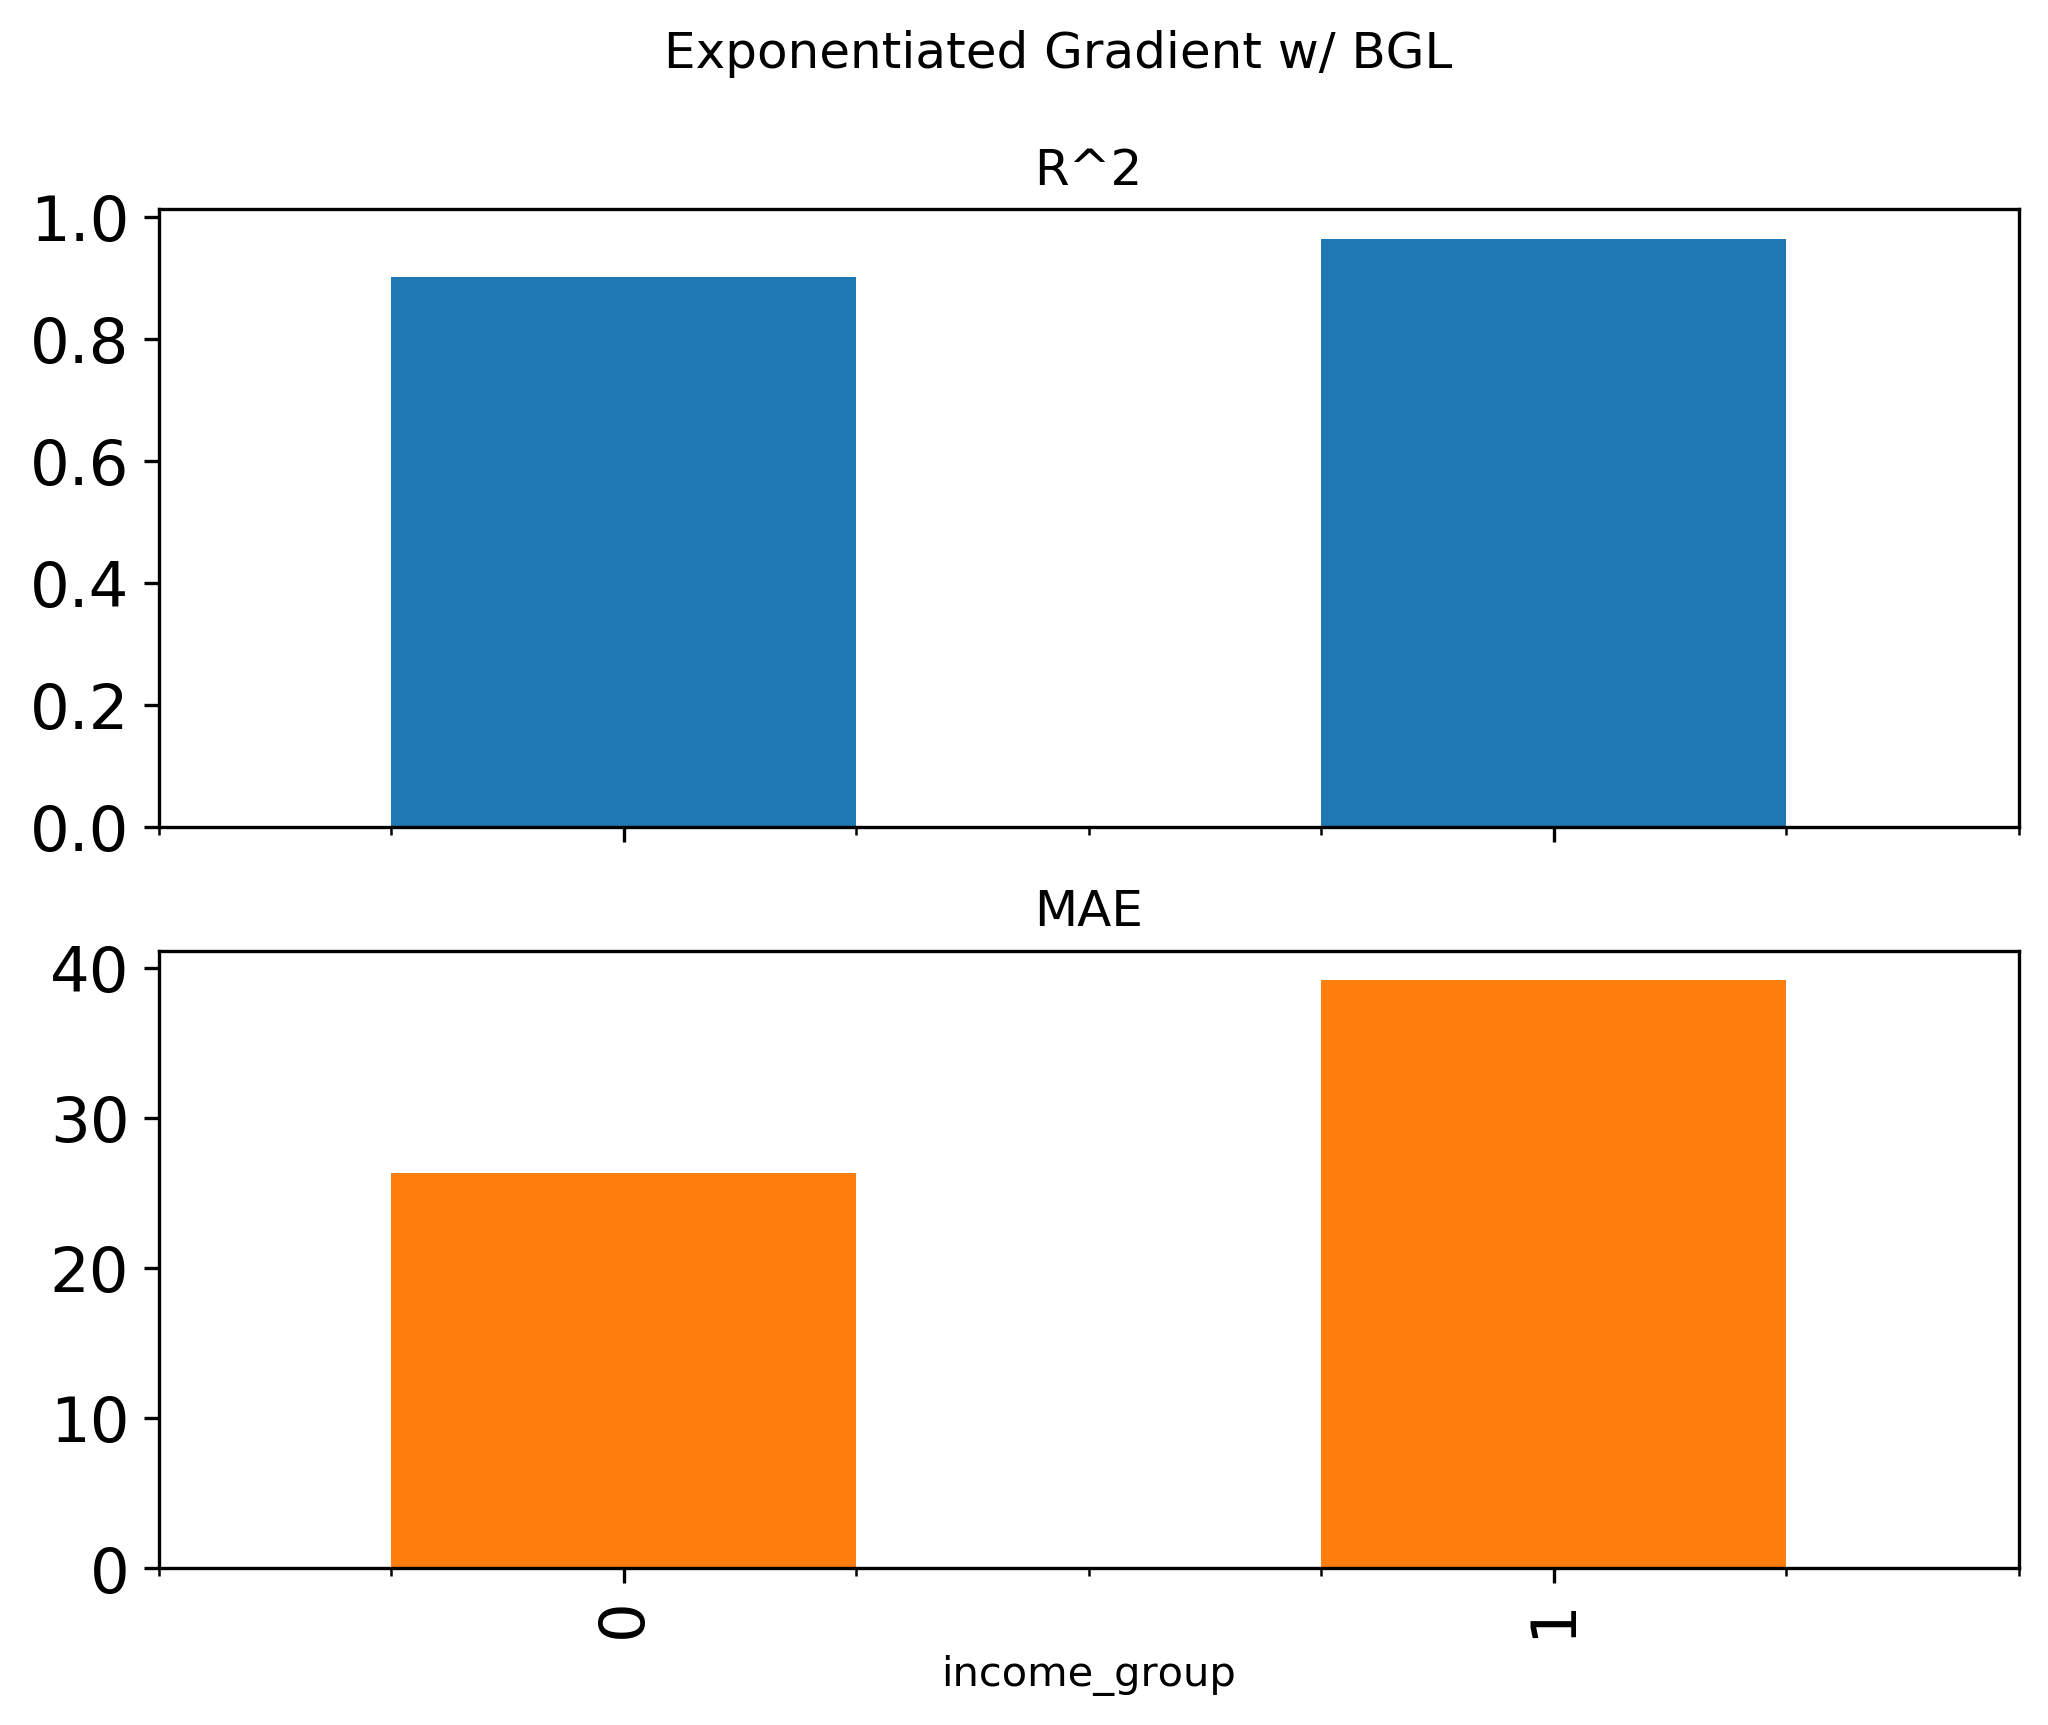

In [46]:
'''
TRAINING SET
'''
y_train_pred = eg_best.predict(X_train, random_state = 42)
metric_frame_eg_train = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                           sensitive_features = A_train,
                           y_true = y_train,
                           y_pred = y_train_pred)

print(metric_frame_eg_train.overall)
print("-"*30)
print(metric_frame_eg_train.by_group)
print()
# print("R^2 diff:", "{:.5f}".format(metric_frame_eg.difference()["R^2"]))
print("R^2 diff:",metric_frame_eg_train.difference()["R^2"])
# print("MAE diff:", "{:.5f}".format(metric_frame_eg.difference()["MAE"]))
print("MAE diff:", metric_frame_eg_train.difference()["MAE"])
print("-"*30)
# print("RFG:", rfg_calc(y_train_pred, y_train, normalized_pop_df, y_test_cell_num))

# save model
# model_summary.loc["exp_grad", "r2"] = metric_frame_eg.overall["R^2"]
# model_summary.loc["exp_grad", "mae"] = metric_frame_eg.overall["MAE"]
# model_summary.loc["exp_grad", "r2_diff"] = metric_frame_eg.difference()["R^2"]
# model_summary.loc["exp_grad", "mae_diff"] = metric_frame_eg.difference()["MAE"]
# model_summary.loc["exp_grad", "rfg"] = rfg_calc(y_pred_eg, y_test, normalized_pop_df, y_test_cell_num)

metric_frame_eg_train.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Exponentiated Gradient w/ BGL', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_metric"))

R^2     0.820235
MAE    89.730464
dtype: object
------------------------------
                   R^2         MAE
income_group                      
0             0.537284   76.785885
1             0.846047  108.166682

R^2 diff: 0.30876248725405064
MAE diff: 31.380797450828652
------------------------------
RFG: 343.0612215243159


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c7bc5a3d0>],
      dtype=object)

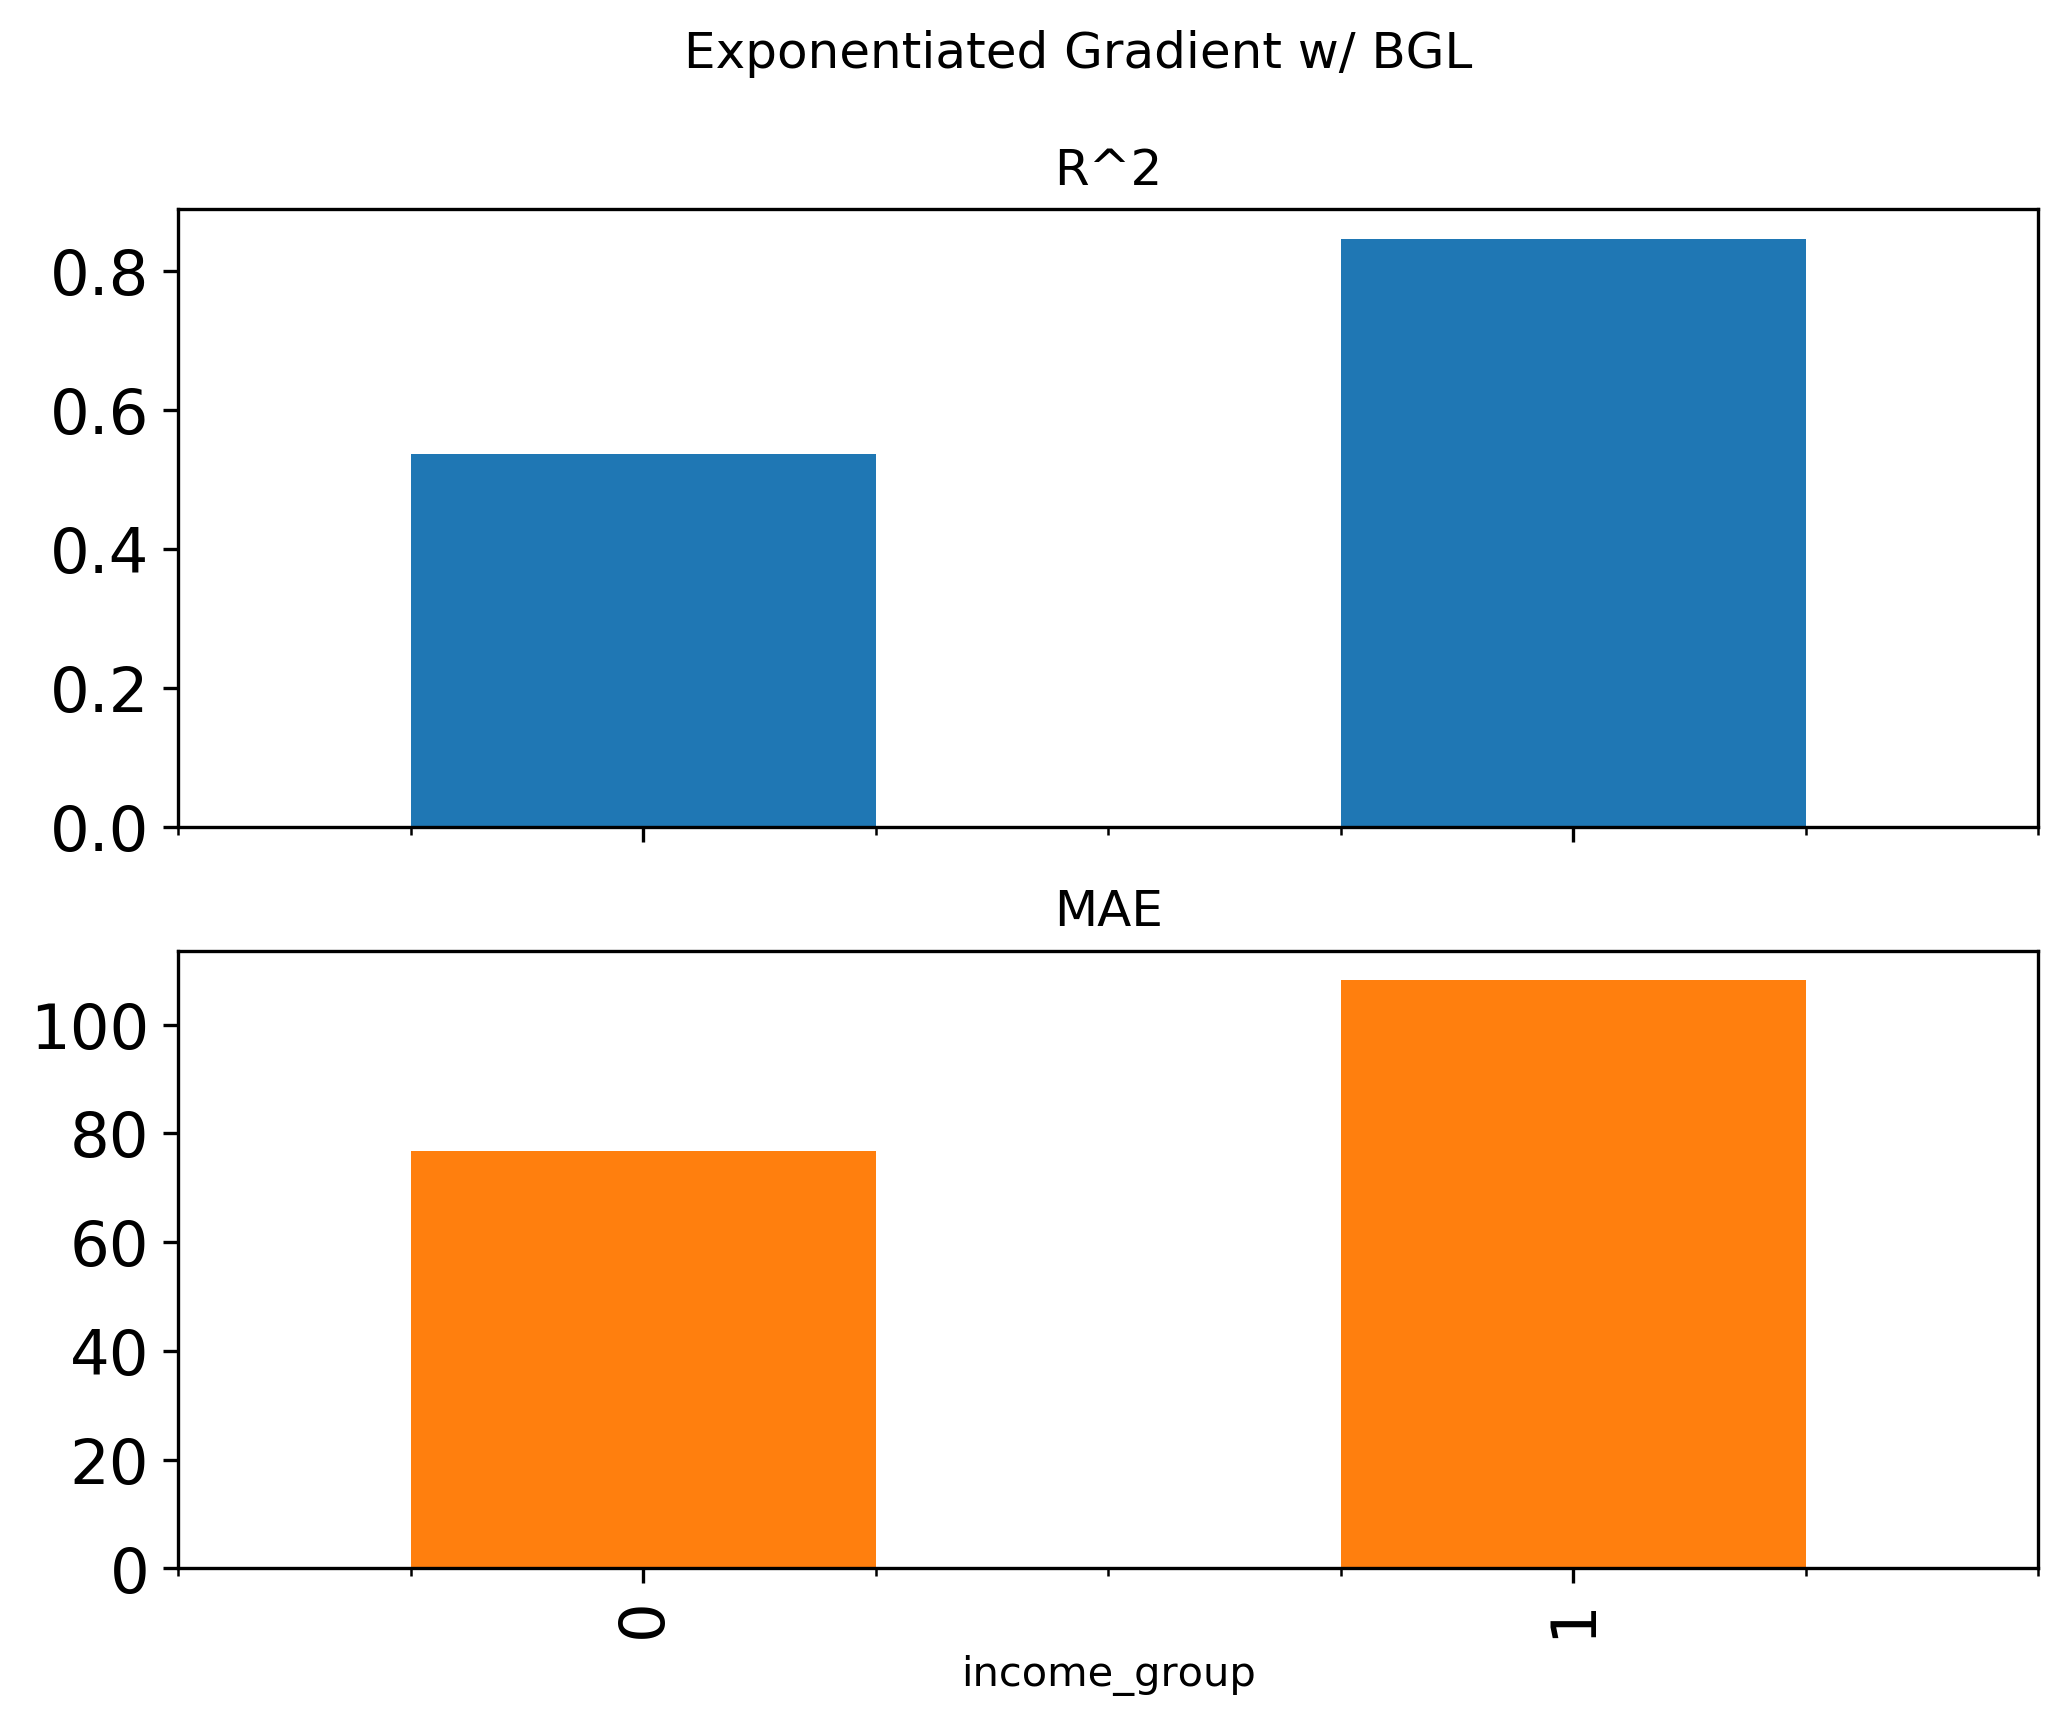

In [47]:
'''
TEST SET
'''

metric_frame_eg = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                           sensitive_features = A_test,
                           y_true = y_test,
                           y_pred = y_pred_eg)

print(metric_frame_eg.overall)
print("-"*30)
print(metric_frame_eg.by_group)
print()
# print("R^2 diff:", "{:.5f}".format(metric_frame_eg.difference()["R^2"]))
print("R^2 diff:",metric_frame_eg.difference()["R^2"])
# print("MAE diff:", "{:.5f}".format(metric_frame_eg.difference()["MAE"]))
print("MAE diff:", metric_frame_eg.difference()["MAE"])
print("-"*30)
print("RFG:", rfg_calc(y_pred_eg, y_test, normalized_pop_df, y_test_cell_num))

# save model
model_summary.loc["exp_grad", "r2"] = metric_frame_eg.overall["R^2"]
model_summary.loc["exp_grad", "mae"] = metric_frame_eg.overall["MAE"]
model_summary.loc["exp_grad", "r2_diff"] = metric_frame_eg.difference()["R^2"]
model_summary.loc["exp_grad", "mae_diff"] = metric_frame_eg.difference()["MAE"]
model_summary.loc["exp_grad", "rfg"] = rfg_calc(y_pred_eg, y_test, normalized_pop_df, y_test_cell_num)

metric_frame_eg.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Exponentiated Gradient w/ BGL', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_metric"))

### 3) Grid Search (constraint: BGL)

In [48]:
# def calc_dominant_avg_res(predictors, X_valid, y_valid, A_valid):
    
#     # Loop through all predictors
#     r2_all = []
#     mae_diff_all = []

#     for i in range(len(predictors)):
#         metric_frame = MetricFrame(metric = {"R^2": skm.r2_score, "MAE": skm.mean_absolute_error}, sensitive_features = A_valid,
#                                    y_true = y_valid, y_pred = predictors[i].predict(X_valid))
#         mae_diff_all.append(metric_frame.difference()['MAE'])
#         r2_all.append(metric_frame.overall["R^2"])
    
#     # get dominant models
#     all_results = pd.DataFrame({"predictors:": predictors, "r2": r2_all, "diff": mae_diff_all})
#     dominated = []
#     for row in all_results.itertuples():
#         '''
#         want the models that have the high R^2 with low difference
#         thus, we select model M if all of other models with higher R^2 than M also have higher difference than M.
#         # i.e. M has the lowest difference among all of the models that have higher R^2 than it.
#         '''
#         difference = all_results["diff"][all_results["r2"] >= row.r2]
#         if row.diff <= difference.min():
#             dominated.append(row[1])
    
#     # loop all of the dominated models
#     r2_dominated = []
#     r2_diff_dominated = []
#     mae_dominated = []
#     mae_diff_dominated = []
    
#     for i in range(len(dominated)):
#         metric_frame_dominated = MetricFrame(metric={"R^2": skm.r2_score,
#                                            "MAE": skm.mean_absolute_error
#                                            },
#                                    sensitive_features = A_valid,
#                                    y_true = y_valid,
#                                    y_pred = dominated[i].predict(X_valid))

#         r2_dominated.append(metric_frame.overall["R^2"])
#         r2_diff_dominated.append(metric_frame_dominated.difference()['R^2'])
#         mae_dominated.append(metric_frame_dominated.overall["MAE"])
#         mae_diff_dominated.append(metric_frame_dominated.difference()['MAE'])
        
#     r2_dominated = np.array(r2_dominated)
#     r2_diff_dominated = np.array(r2_diff_dominated)
#     mae_dominated = np.array(mae_dominated)
#     mae_diff_dominated = np.array(mae_diff_dominated)

#     return np.nanmean(r2_dominated), np.nanmean(r2_diff_dominated), np.nanmean(mae_dominated), np.nanmean(mae_diff_dominated), dominated

In [49]:
# # cross validation for grid search 
# # implement K-fold cross validation
# grid_size_ls = np.arange(0, 22, 2)[1:]

# grid_search_result = pd.DataFrame({"grid_size": grid_size_ls})

# for i in np.arange(len(grid_size_ls)):
#     print(i)
#     g_size = grid_size_ls[i]
    
#     # train-valid split
#     kfold = KFold(3, shuffle = True, random_state = 42)
#     for train, valid in kfold.split(X_train):
#         # print("CV")
#         X_train_gs = X_train.loc[train]
#         y_train_gs = y_train.loc[train]
#         A_train_gs = A_train.loc[train]

#         X_valid = X_train.loc[valid]
#         y_valid = y_train.loc[valid]
#         A_valid = A_train.loc[valid]

#         # avoid failure of optimization
#         try:
#             # train
#             mitigator = GridSearch(estimator = rf_best,
#                        constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound_l[best_eg_index]),
#                        grid_size = g_size)

#             mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
#             predictors = mitigator.predictors_

#             # calculate dominant models res
#             dominant_res = calc_dominant_avg_res(predictors, X_valid, y_valid, A_valid)

#             grid_search_result.loc[i, "cv_avg_r2"] = dominant_res[0]
#             grid_search_result.loc[i, "cv_avg_r2_diff"] = dominant_res[1]
#             grid_search_result.loc[i, "cv_avg_mae"] = dominant_res[2]
#             grid_search_result.loc[i, "cv_avg_mae_diff"] = dominant_res[3]

#         except:
#             grid_search_result.loc[i, "cv_avg_r2"] = np.nan
#             grid_search_result.loc[i, "cv_avg_r2_diff"] = np.nan
#             grid_search_result.loc[i, "cv_avg_mae"] = np.nan
#             grid_search_result.loc[i, "cv_avg_mae_diff"] = np.nan

#     grid_search_result.to_csv(os.path.join(save_dir_models, CITY+"grid_search_valid_res.csv"))

In [50]:
# grid_search_result

In [51]:
# best_gs_index = grid_search_result[grid_search_result.cv_avg_mae_diff == grid_search_result.cv_avg_mae_diff.min()].index[0]
# print("best grid size for Grid Search:", grid_size_ls[best_gs_index])

# # plot
# plt.figure(figsize = (25, 8))
# plt.plot(grid_search_result.grid_size, grid_search_result.cv_avg_mae_diff)
# plt.scatter(grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].grid_size, grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, color = "red")
# # plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
# plt.xlabel("upper bound in BGL", fontsize = 15)
# plt.ylabel("MAE difference", fontsize = 15)
# plt.text(x = grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].grid_size+0.0005, y = grid_search_result.iloc[grid_search_result.cv_avg_mae_diff.argmin()].cv_avg_mae_diff, s = 'min', color = "red")
# plt.title("Cross Validation MAE diff for parameter 'upper_bound' \nin Bounded Group Loss for Exponentiated Gradient", fontsize = 18)
# plt.title("Grid Search cross validation result: MAE difference vs. 'grid_size'", fontsize = 18)
# plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_valid_res"))

In [52]:
# # get all predictors according to best grid size
# mitigator = GridSearch(estimator = rf_best,
#                        constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound_l[best_eg_index]),
#                        grid_size = grid_size_ls[best_gs_index])

In [53]:
# kfold = KFold(2, shuffle = True, random_state = 42)

# # randomly get train valid set
# for train, valid in kfold.split(X_train):
#     # print("CV")
#     X_train_gs = X_train.loc[train]
#     y_train_gs = y_train.loc[train]
#     A_train_gs = A_train.loc[train]

#     X_valid = X_train.loc[valid]
#     y_valid = y_train.loc[valid]
#     A_valid = A_train.loc[valid]

In [54]:
# # get all predictors according to best grid size
# mae_diff_all = []
# r2_all = []

# mitigator = GridSearch(estimator = rf_best,
#                        constraints = BoundedGroupLoss(loss = AbsoluteLoss(-np.inf, np.inf), upper_bound = diff_bound_l[best_eg_index]),
#                        grid_size = grid_size_ls[best_gs_index])

# mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
# predictors = mitigator.predictors_

In [55]:
# # get dominant model on valid set
# for i in range(len(predictors)):
#     metric_frame = MetricFrame(metric = {"R^2": skm.r2_score, "MAE": skm.mean_absolute_error}, 
#                                sensitive_features = A_valid,
#                                y_true = y_valid, 
#                                y_pred = predictors[i].predict(X_valid))
#     mae_diff_all.append(metric_frame.difference()['MAE'])
#     r2_all.append(metric_frame.overall["R^2"])


# # get dominant models
# all_results = pd.DataFrame({"predictors:": predictors, "r2": r2_all, "diff": mae_diff_all})
# gs_dominant_final = []

# for row in all_results.itertuples():
#     '''
#     want the models that have the high R^2 with low difference
#     thus, we select model M if all of other models with higher R^2 than M also have higher difference than M.
#     # i.e. M has the lowest difference among all of the models that have higher R^2 than it.
#     '''
#     difference = all_results["diff"][all_results["r2"] >= row.r2]
#     if row.diff <= difference.min():
#         gs_dominant_final.append(row[1])

In [56]:
# # loop all of the dominant models on test set
# r2_dominated = []
# mae_diff_dominated = []

# for i in range(len(gs_dominant_final)):
#     metric_frame_dominant = MetricFrame(metric={"R^2": skm.r2_score,
#                                        "MAE": skm.mean_absolute_error},
#                                sensitive_features = A_test,
#                                y_true = y_test,
#                                y_pred = gs_dominant_final[i].predict(X_test))

#     mae_diff_dominated.append(metric_frame_dominant.difference()['MAE'])
#     r2_dominated.append(metric_frame_dominant.overall["R^2"])

In [57]:
# # calculate gs model with lowest MAE diff
# gs_least_mae_idx = np.argmin(np.array(mae_diff_dominated))
# gs_least_mae_idx

In [58]:
gs_dominant_model = pickle.load(open(os.path.join(save_dir_models, CITY + "grid_search.pkl"), 'rb'))

#### Selected Grid Search model

R^2     0.928093
MAE    44.485505
dtype: object
------------------------------
                   R^2        MAE
income_group                     
0             0.819191  34.870583
1             0.935492  54.730618

R^2 diff: 0.11630
MAE diff: 19.86003
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c7ca8cf90>],
      dtype=object)

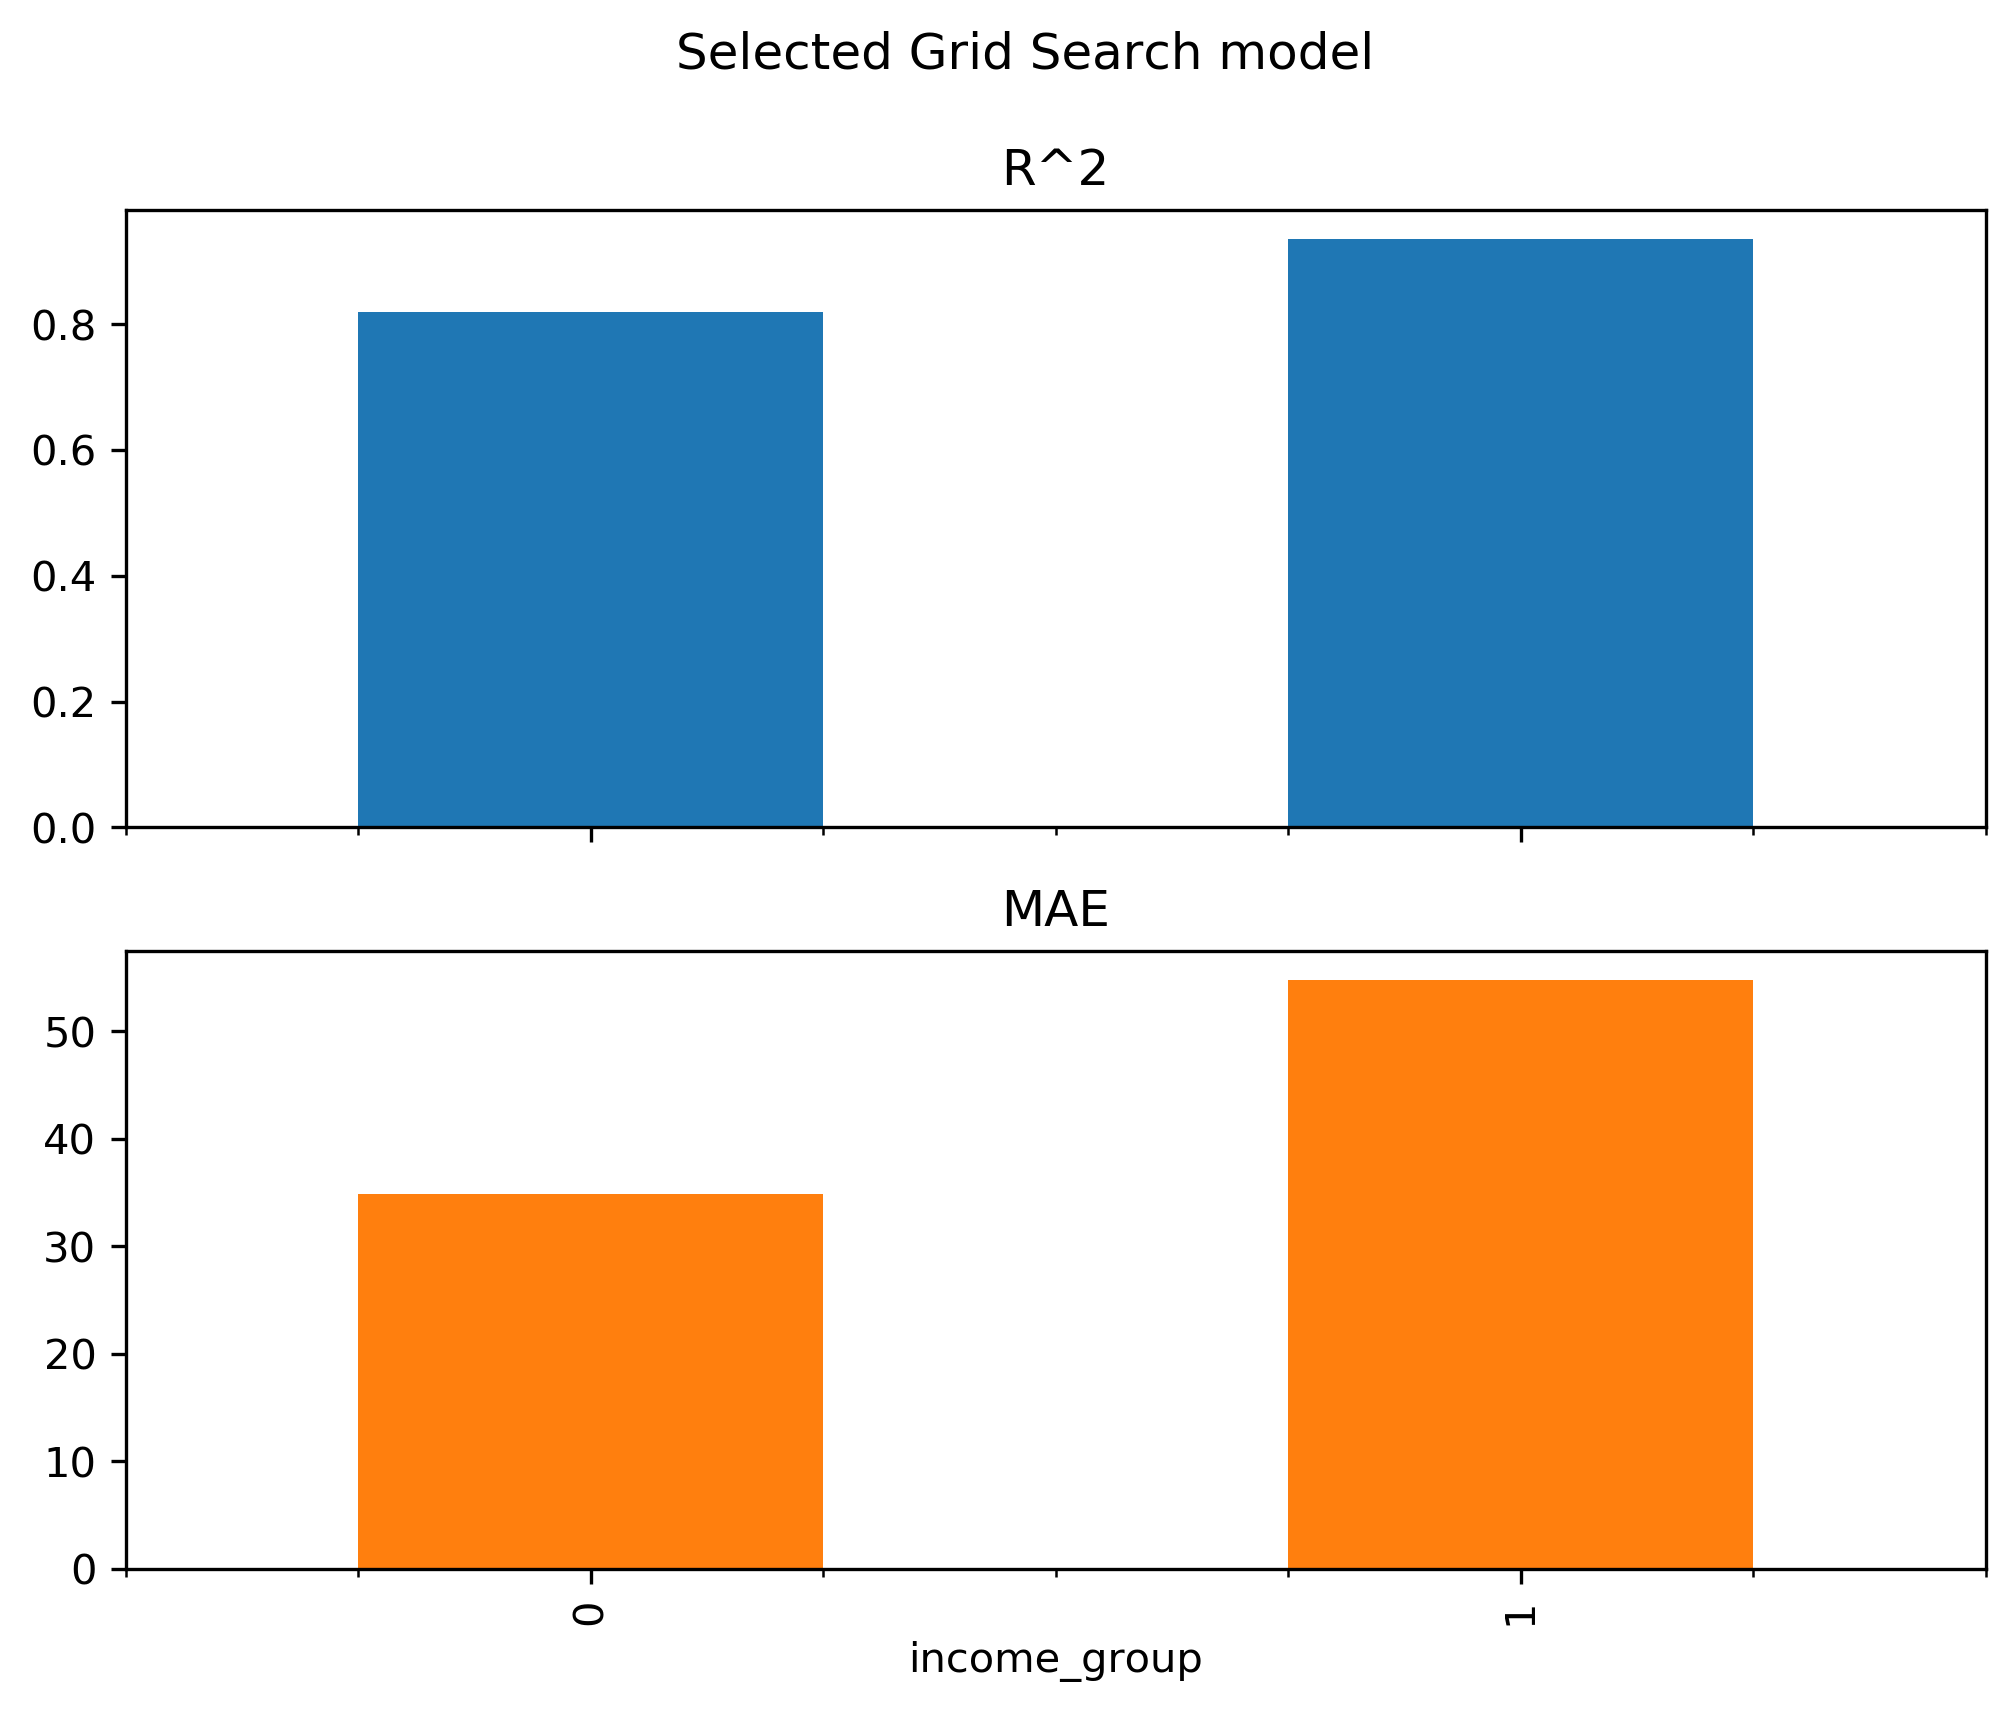

In [59]:
'''
Train set
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs_train = gs_dominant_model.predict(X_train)
metric_frame_gs_train = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                               sensitive_features = A_train,
                               y_true = y_train,
                               y_pred = y_pred_gs_train)

print(metric_frame_gs_train.overall)
print("-"*30)
print(metric_frame_gs_train.by_group)
print()
print("R^2 diff:", "{:.5f}".format(metric_frame_gs_train.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_gs_train.difference()["MAE"]))
print("-"*30)

# # save model
# model_summary.loc["grid_search", "r2"] = metric_frame_gs_train.overall["R^2"]
# model_summary.loc["grid_search", "mae"] = metric_frame_gs_train.overall["MAE"]
# model_summary.loc["grid_search", "r2_diff"] = metric_frame_gs_train.difference()["R^2"]
# model_summary.loc["grid_search", "mae_diff"] = metric_frame_gs_train.difference()["MAE"]
# model_summary.loc["grid_search", "rfg"] = rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num)

# print("RFG:", rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num))
metric_frame_gs_train.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Selected Grid Search model')

# plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_metric"))

R^2     0.807688
MAE    92.086145
dtype: object
------------------------------
                   R^2         MAE
income_group                      
0             0.488298   79.443448
1             0.837604  110.092409

R^2 diff: 0.34931
MAE diff: 30.64896
------------------------------
RFG: 357.85500190921573


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c7db32c50>],
      dtype=object)

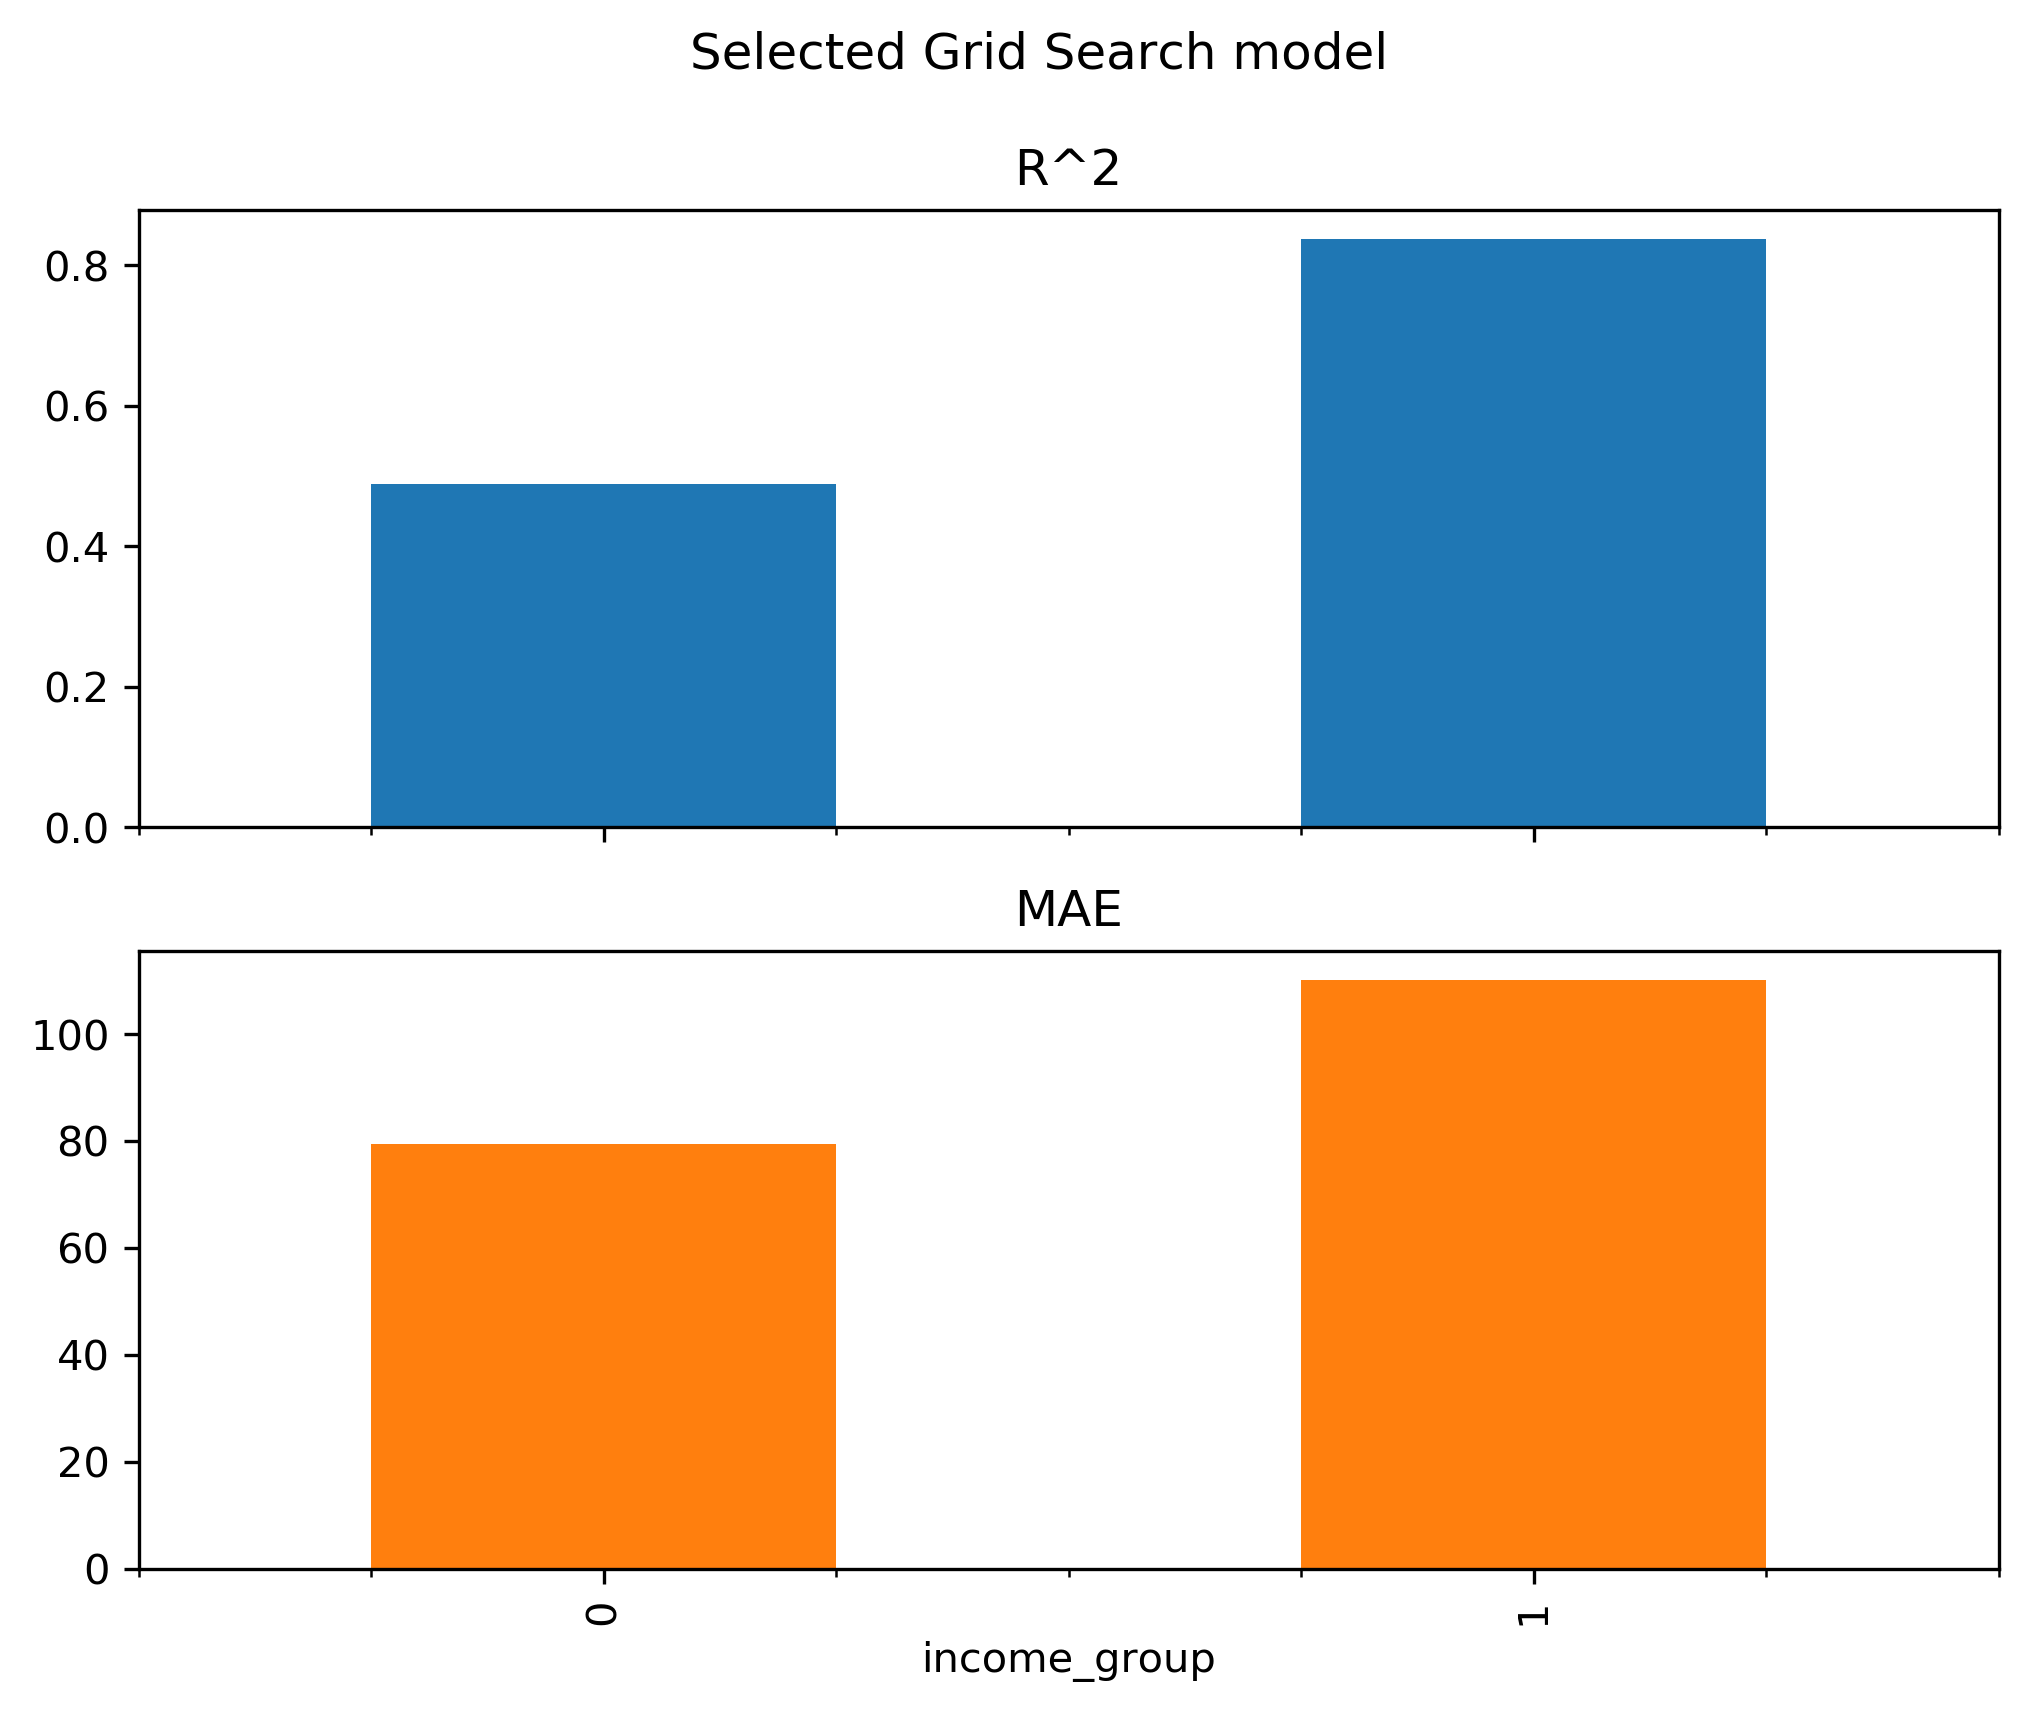

In [60]:
'''
Test set
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs = gs_dominant_model.predict(X_test)
metric_frame_gs = MetricFrame(metric = {"R^2": skm.r2_score,
                                       "MAE": skm.mean_absolute_error},
                               sensitive_features = A_test,
                               y_true = y_test,
                               y_pred = y_pred_gs)

print(metric_frame_gs.overall)
print("-"*30)
print(metric_frame_gs.by_group)
print()
print("R^2 diff:", "{:.5f}".format(metric_frame_gs.difference()["R^2"]))
print("MAE diff:", "{:.5f}".format(metric_frame_gs.difference()["MAE"]))
print("-"*30)

# save model
model_summary.loc["grid_search", "r2"] = metric_frame_gs.overall["R^2"]
model_summary.loc["grid_search", "mae"] = metric_frame_gs.overall["MAE"]
model_summary.loc["grid_search", "r2_diff"] = metric_frame_gs.difference()["R^2"]
model_summary.loc["grid_search", "mae_diff"] = metric_frame_gs.difference()["MAE"]
model_summary.loc["grid_search", "rfg"] = rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num)

print("RFG:", rfg_calc(y_pred_gs, y_test, normalized_pop_df, y_test_cell_num))
metric_frame_gs.by_group.plot.bar(
        subplots=True, layout=[2, 1], legend=False, figsize=[8, 6],
        title='Selected Grid Search model')

# plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_metric"))

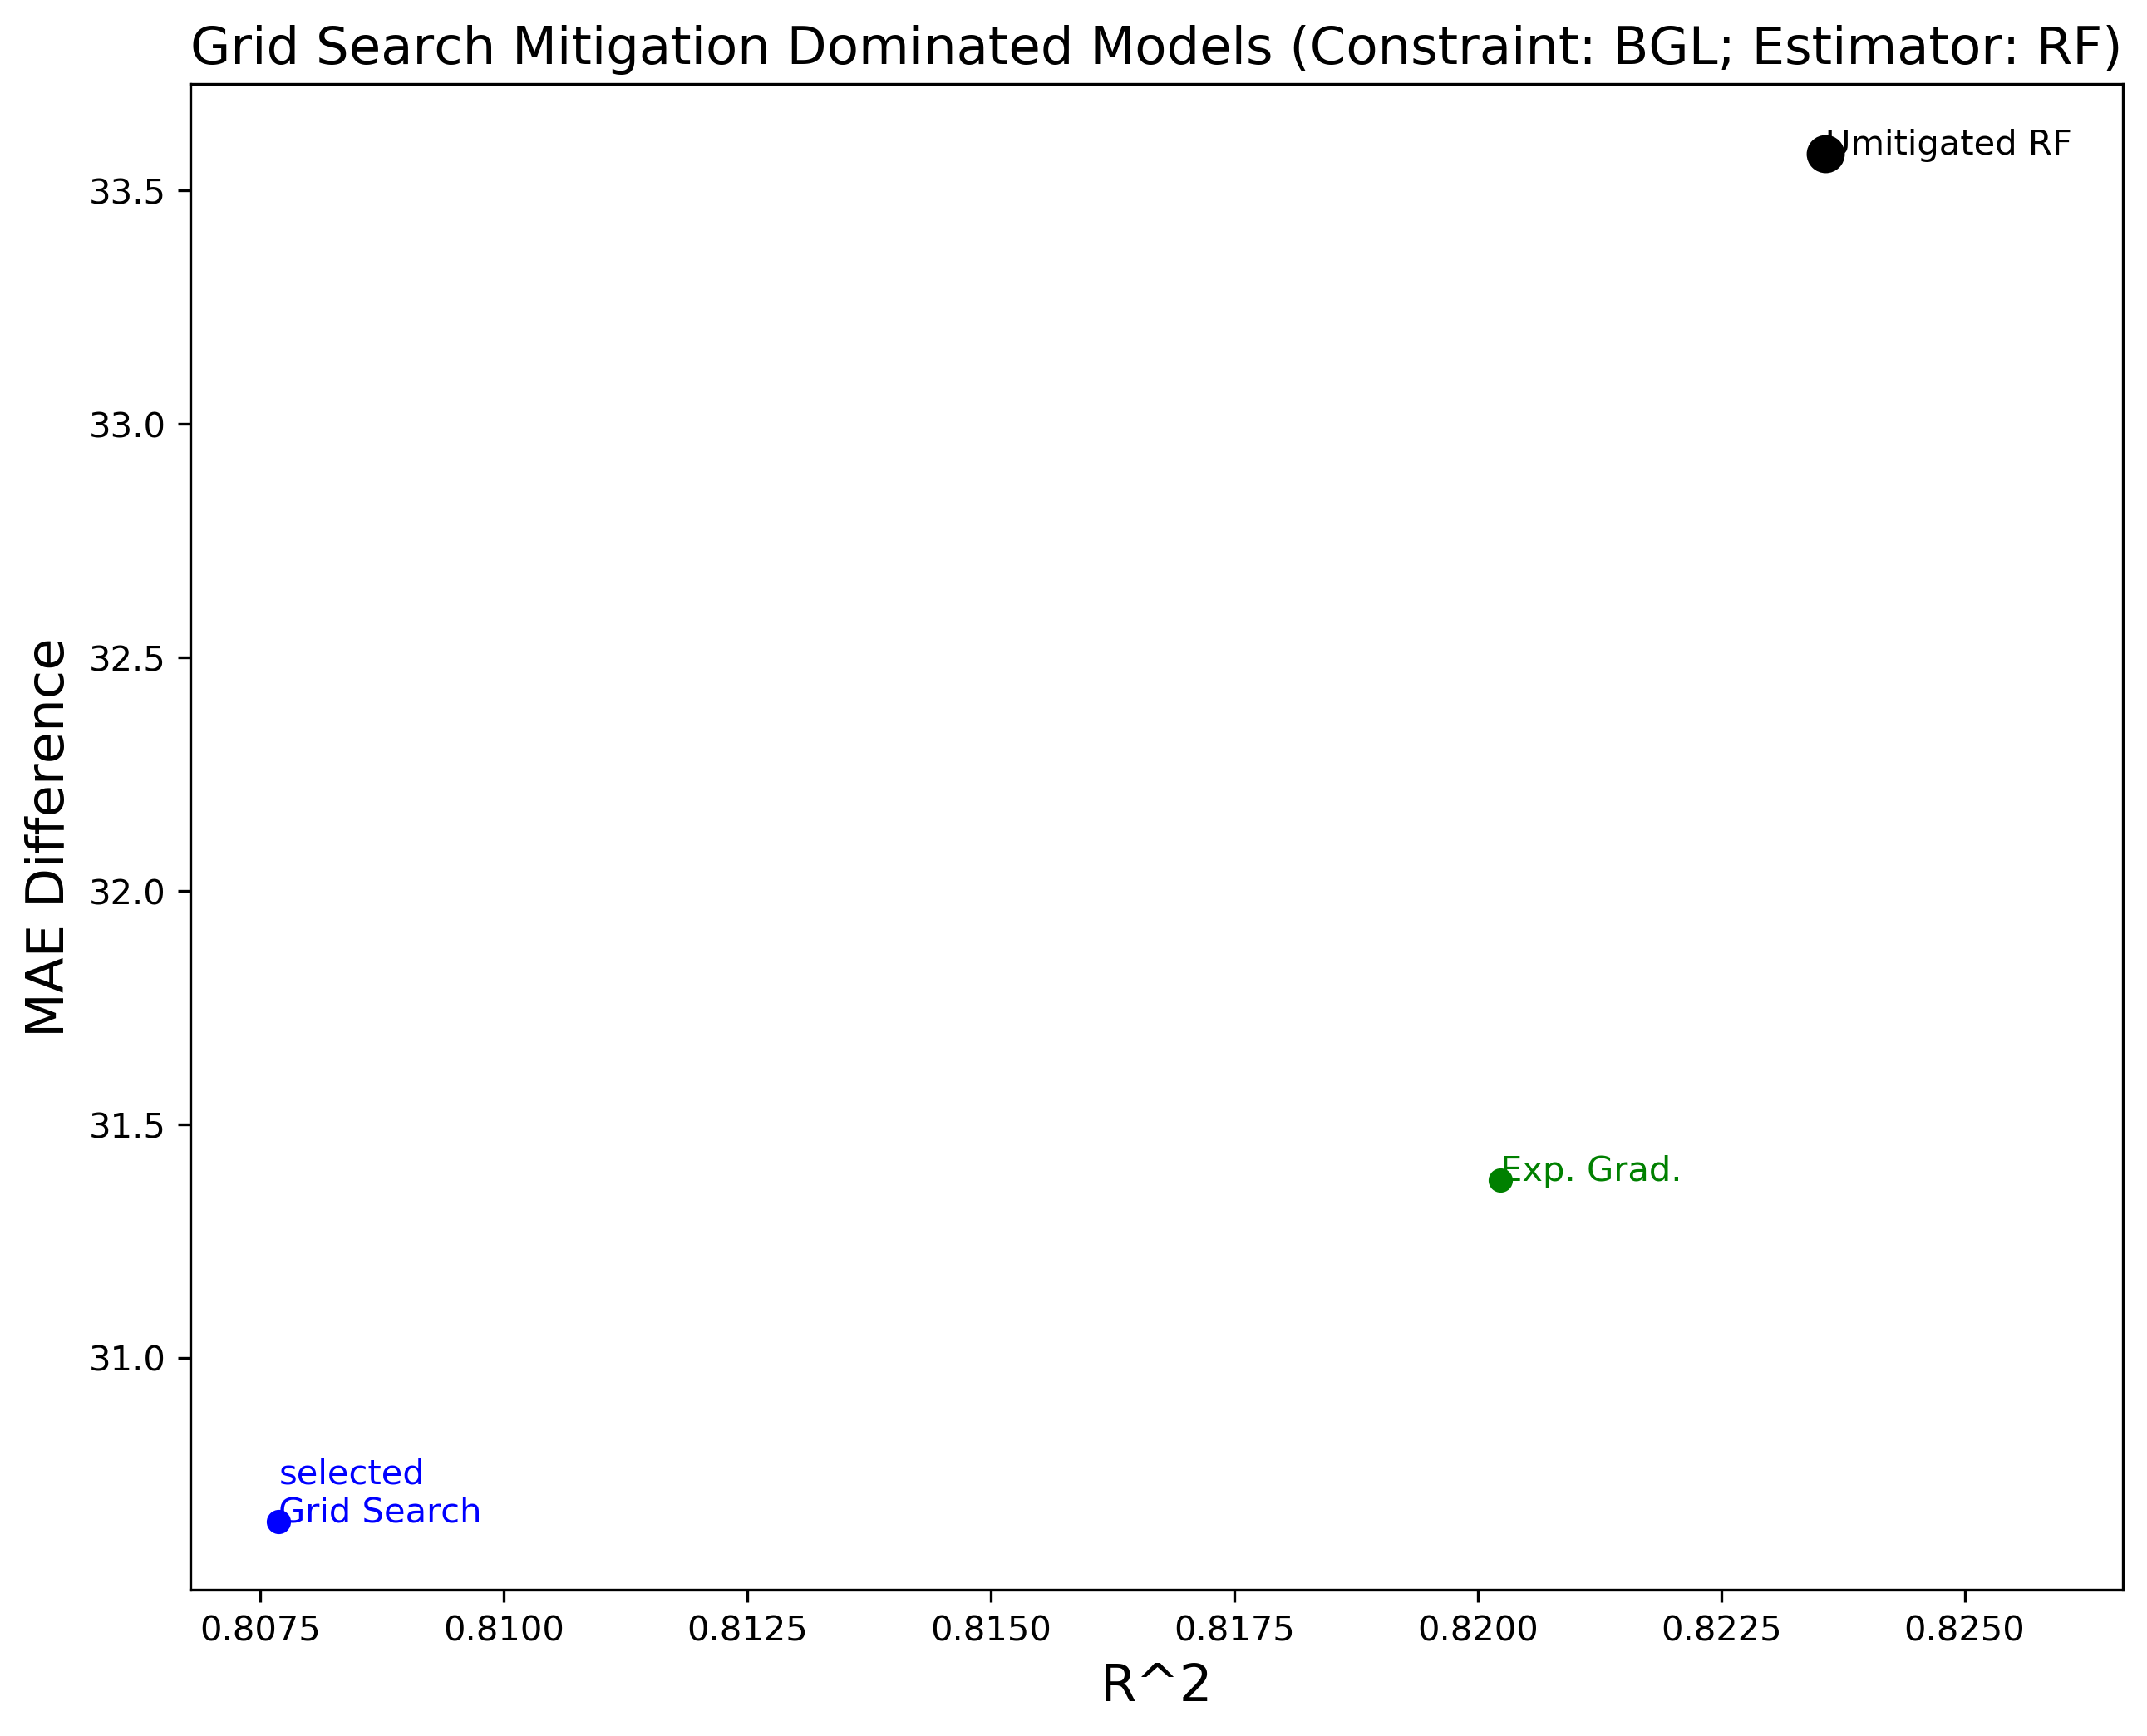

In [61]:
# plot only the dominated models

plt.figure(figsize = (10, 8))
# plt.scatter(r2_dominated, mae_diff_dominated)

# Label previous fair-unaware model
plt.scatter(metric_frame_rf_gs.overall["R^2"], metric_frame_rf_gs.difference()['MAE'], color = 'black', s = 100)
plt.text(metric_frame_rf_gs.overall["R^2"], metric_frame_rf_gs.difference()['MAE'], "Umitigated RF", color = 'black')

# Selected grid search model
plt.scatter(metric_frame_gs.overall["R^2"], metric_frame_gs.difference()['MAE'], color = 'blue')
plt.text(metric_frame_gs.overall["R^2"], metric_frame_gs.difference()['MAE'], "selected\nGrid Search", color = 'blue')

# exponentiated gradient
plt.scatter(metric_frame_eg.overall['R^2'], metric_frame_eg.difference()['MAE'], color = 'green')
plt.text(metric_frame_eg.overall['R^2'], metric_frame_eg.difference()['MAE'], "Exp. Grad.", color = 'green')

plt.xlabel("R^2", fontsize = 15)
plt.ylabel("MAE Difference", fontsize = 15)
plt.title("Grid Search Mitigation Dominated Models (Constraint: BGL; Estimator: RF)", fontsize = 15)
# plt.xlim((0.806, 0.811))
plt.savefig(os.path.join(save_dir_models, CITY +"models_scatter_res"))

In [62]:
# # save grid search model
# Pkl_Filename = "grid_search.pkl"  
# with open(os.path.join(save_dir_forecast, CITY +Pkl_Filename), 'wb') as file:  
#     pickle.dump(gs_dominant_final[gs_least_mae_idx], file)

In [2]:
# save model statistics
model_summary.to_csv(os.path.join(save_dir_models, CITY+"model_summary.csv"))

## Visualize

In [64]:
df_geo

,cell_num,geometry,centroid,tract_id,stations
0,104,"POLYGON ((-85.46347 34.98311, -85.46347 34.987...",POINT (-85.46117705986944 34.98540773740939),47065012100,0
1,105,"POLYGON ((-85.46347 34.98770, -85.46347 34.992...",POINT (-85.46117705986944 34.98999852594654),47065012100,0
2,156,"POLYGON ((-85.45888 34.98311, -85.45888 34.987...",POINT (-85.4565862713323 34.98540773740939),47065012100,0
3,157,"POLYGON ((-85.45888 34.98770, -85.45888 34.992...",POINT (-85.4565862713323 34.98999852594654),47065012100,0
4,158,"POLYGON ((-85.45888 34.99229, -85.45888 34.996...",POINT (-85.4565862713323 34.99458931448369),47065012100,0
...,...,...,...,...,...
1825,4651,"POLYGON ((-85.06407 35.08870, -85.06407 35.093...",POINT (-85.06177845713674 35.09099587376386),47065011201,0
1826,4652,"POLYGON ((-85.06407 35.09329, -85.06407 35.097...",POINT (-85.06177845713674 35.095586662301),47065011201,0
1827,4704,"POLYGON ((-85.05948 35.09329, -85.05948 35.097...",POINT (-85.05718766859957 35.095586662301),47065011201,0
1828,4705,"POLYGON ((-85.05948 35.09788, -85.05948 35.102...",POINT (-85.05718766859957 35.10017745083816),47065011201,0


Text(0.5, 1, 'Outflow Ground Truth in 2019')

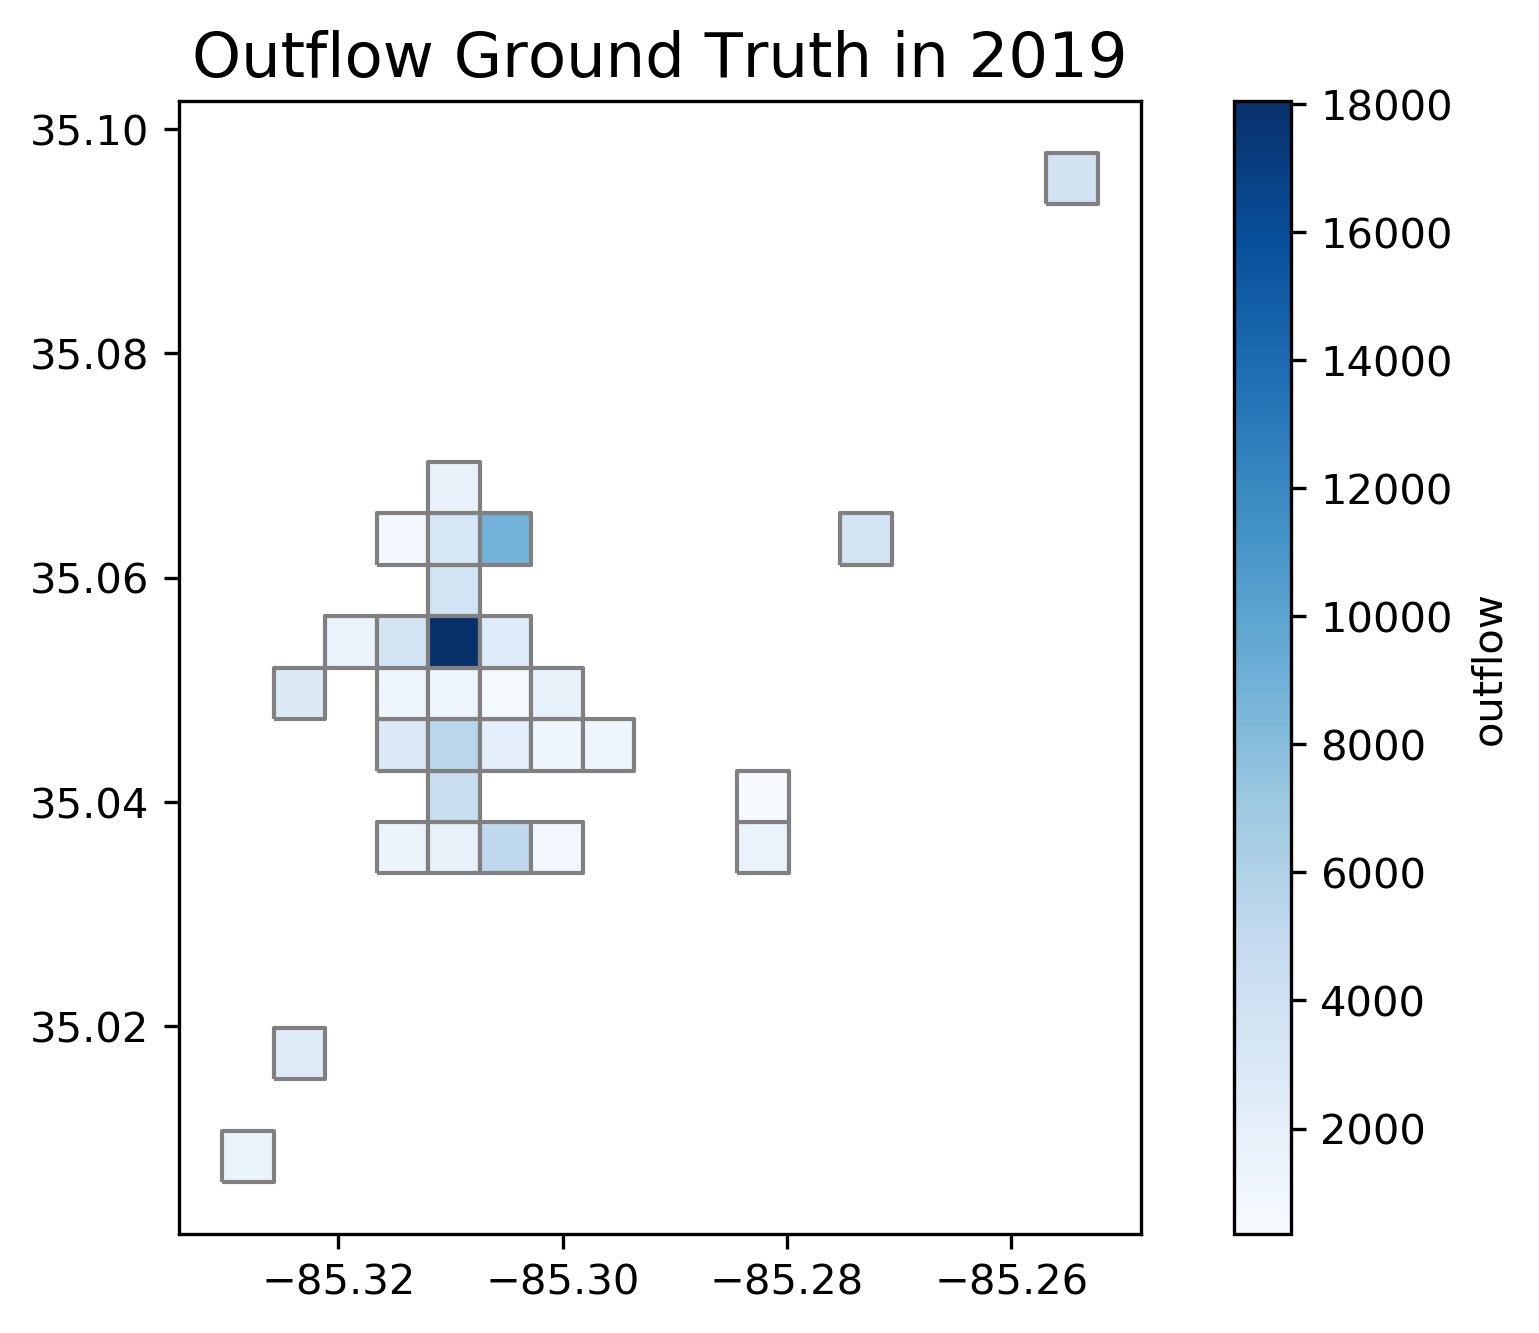

In [65]:
unmitigated_df = pd.DataFrame({ "cell_num": df_19.cell_num.values,
                                "y_pred": y_pred_rf_gs,
                                "y_true": df_19.outflow.values})
# sum within a cell
unmitigated_df = unmitigated_df.groupby("cell_num").sum()
unmitigated_df_plot = unmitigated_df.merge(df_geo, how='left', on = 'cell_num')

geo_cells_unmitigated = gpd.GeoDataFrame(unmitigated_df_plot, crs='EPSG:2956', geometry='geometry')
geo_cells_unmitigated.plot(column="y_true", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"})
plt.title("Outflow Ground Truth in 2019", fontsize = 15)

Text(0.5, 1, 'Unmitigated random forest outflow in 2019')

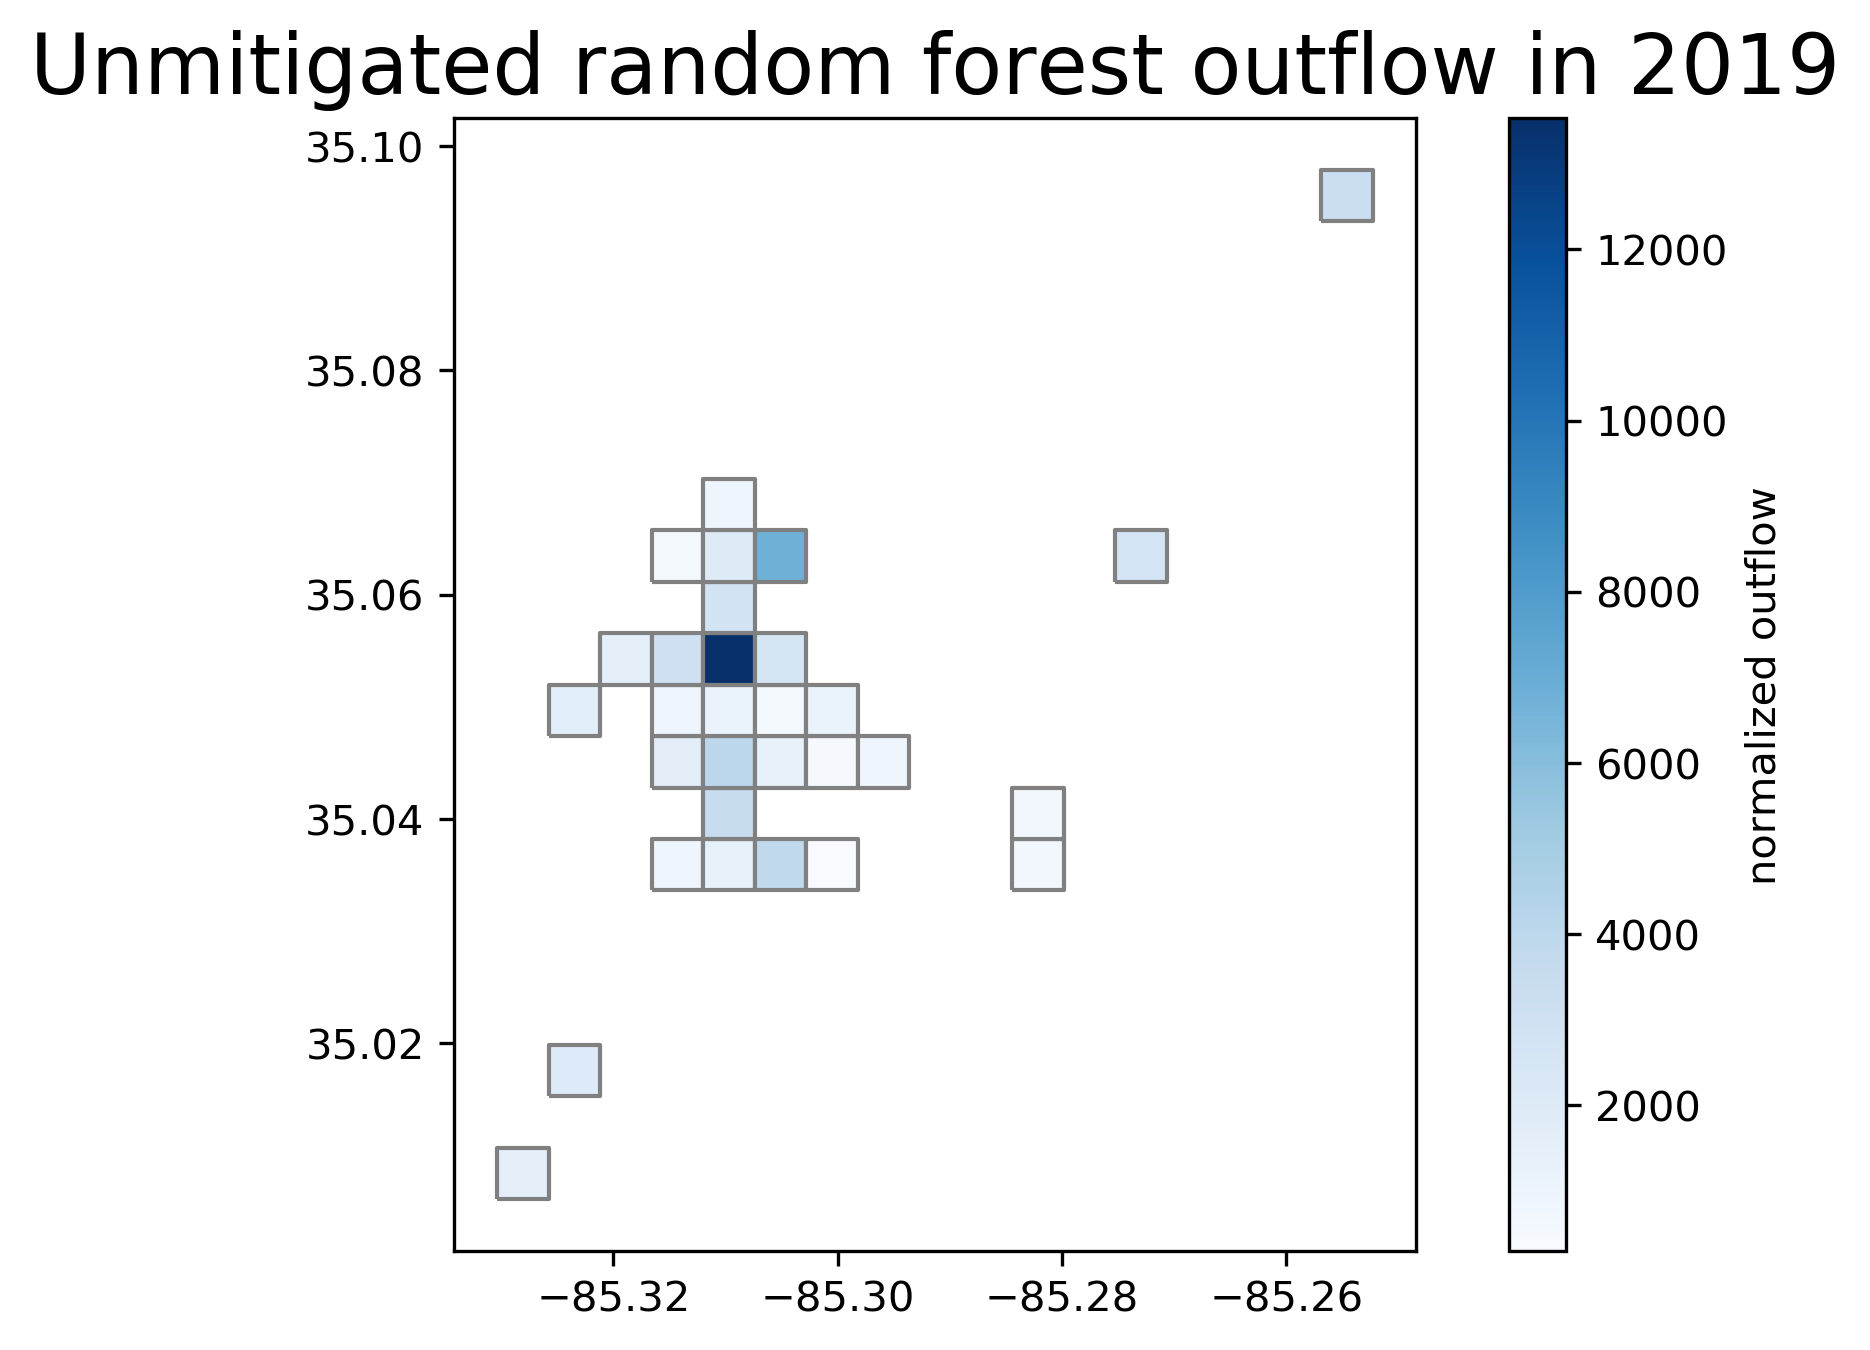

In [66]:
geo_cells_unmitigated.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "normalized outflow",'orientation': "vertical"})
plt.title("Unmitigated random forest outflow in 2019", fontsize = 20)

Text(0.5, 1, 'Exp Grad prediction in 2019')

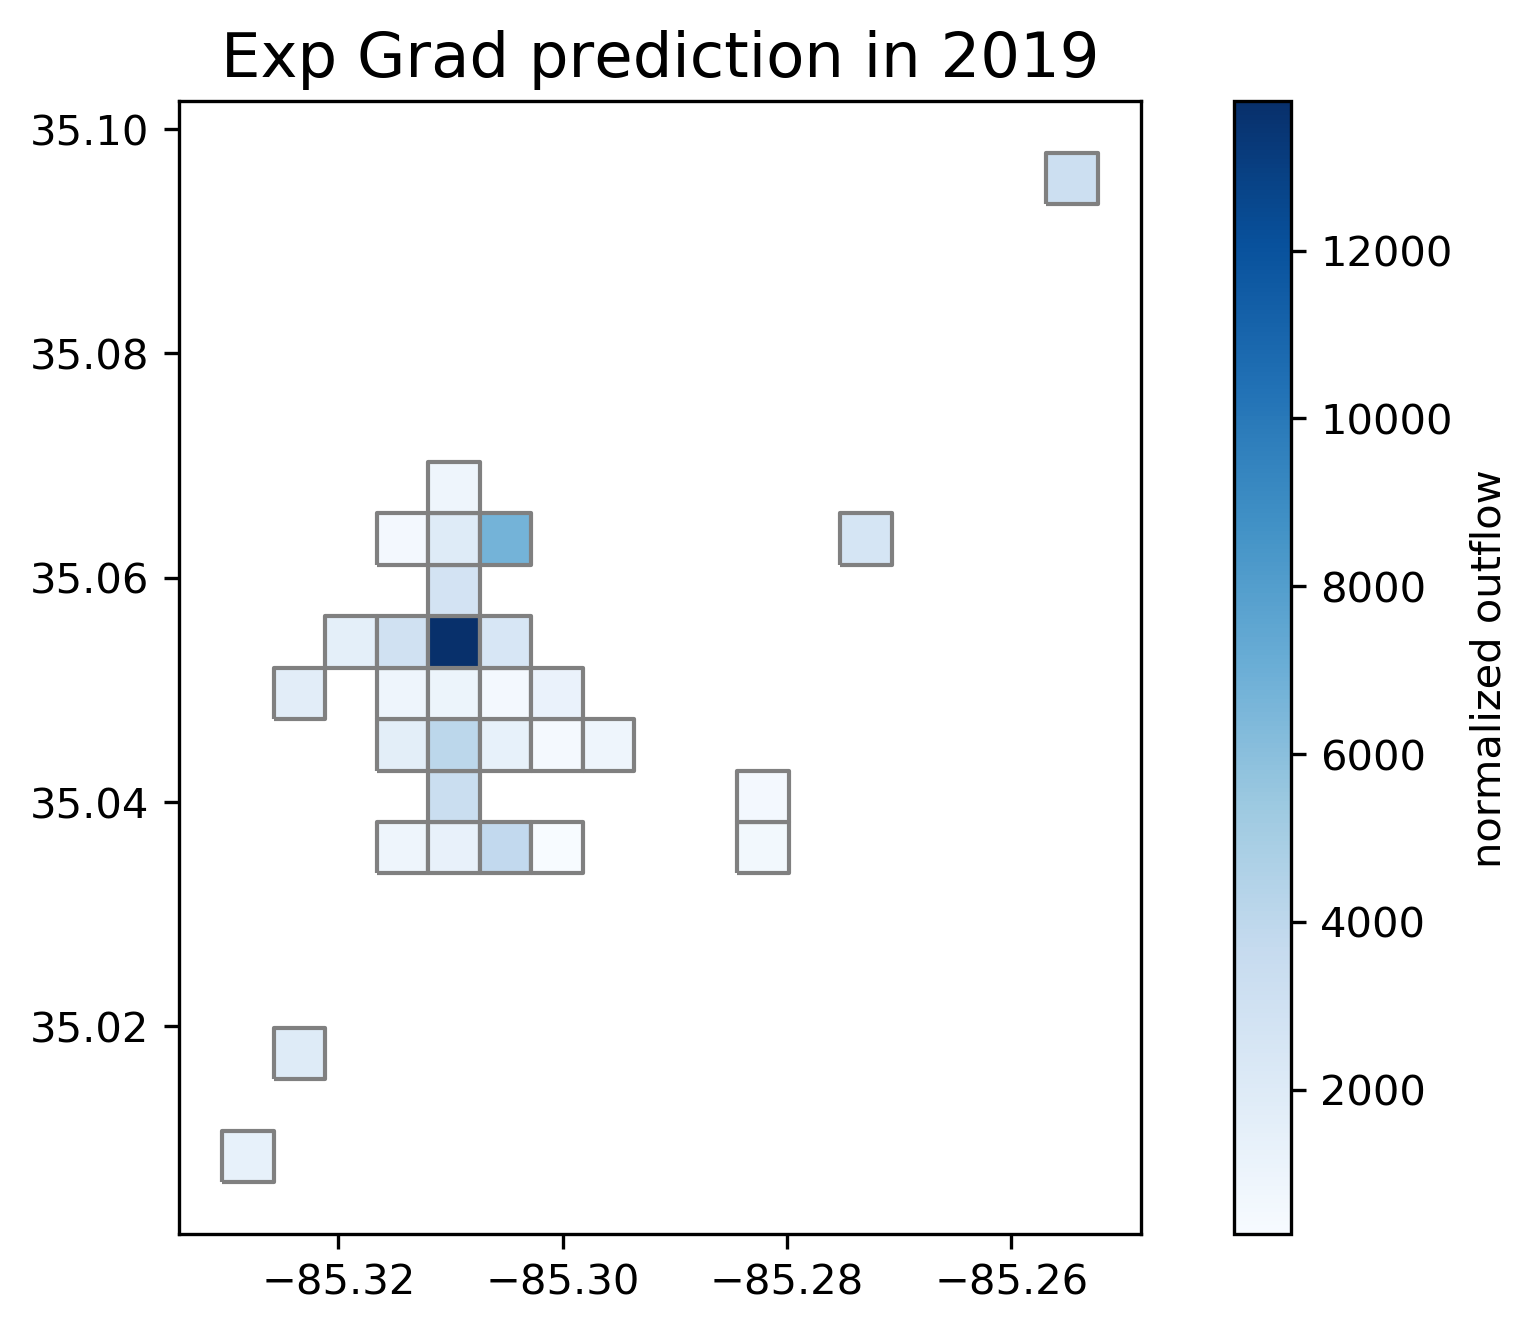

In [67]:
mitigated_eg_df = pd.DataFrame({"cell_num": df_19.cell_num.values,
                                "y_pred": y_pred_eg,
                                "y_true": y_test})
mitigated_eg_df = mitigated_eg_df.groupby("cell_num").sum()
mitigated_eg_df_plot = mitigated_eg_df.merge(df_geo, how='left', on = 'cell_num')
geo_cells_mitigated_eg = gpd.GeoDataFrame(mitigated_eg_df_plot, crs='EPSG:2956', geometry='geometry')

geo_cells_mitigated_eg.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "normalized outflow",'orientation': "vertical"})
# plt.title("Mitigated with Exponentiated Gradient (low accuracy, low disparity)")
plt.title("Exp Grad prediction in 2019", fontsize = 15)

Text(0.5, 1, 'Grid Search prediction 2019')

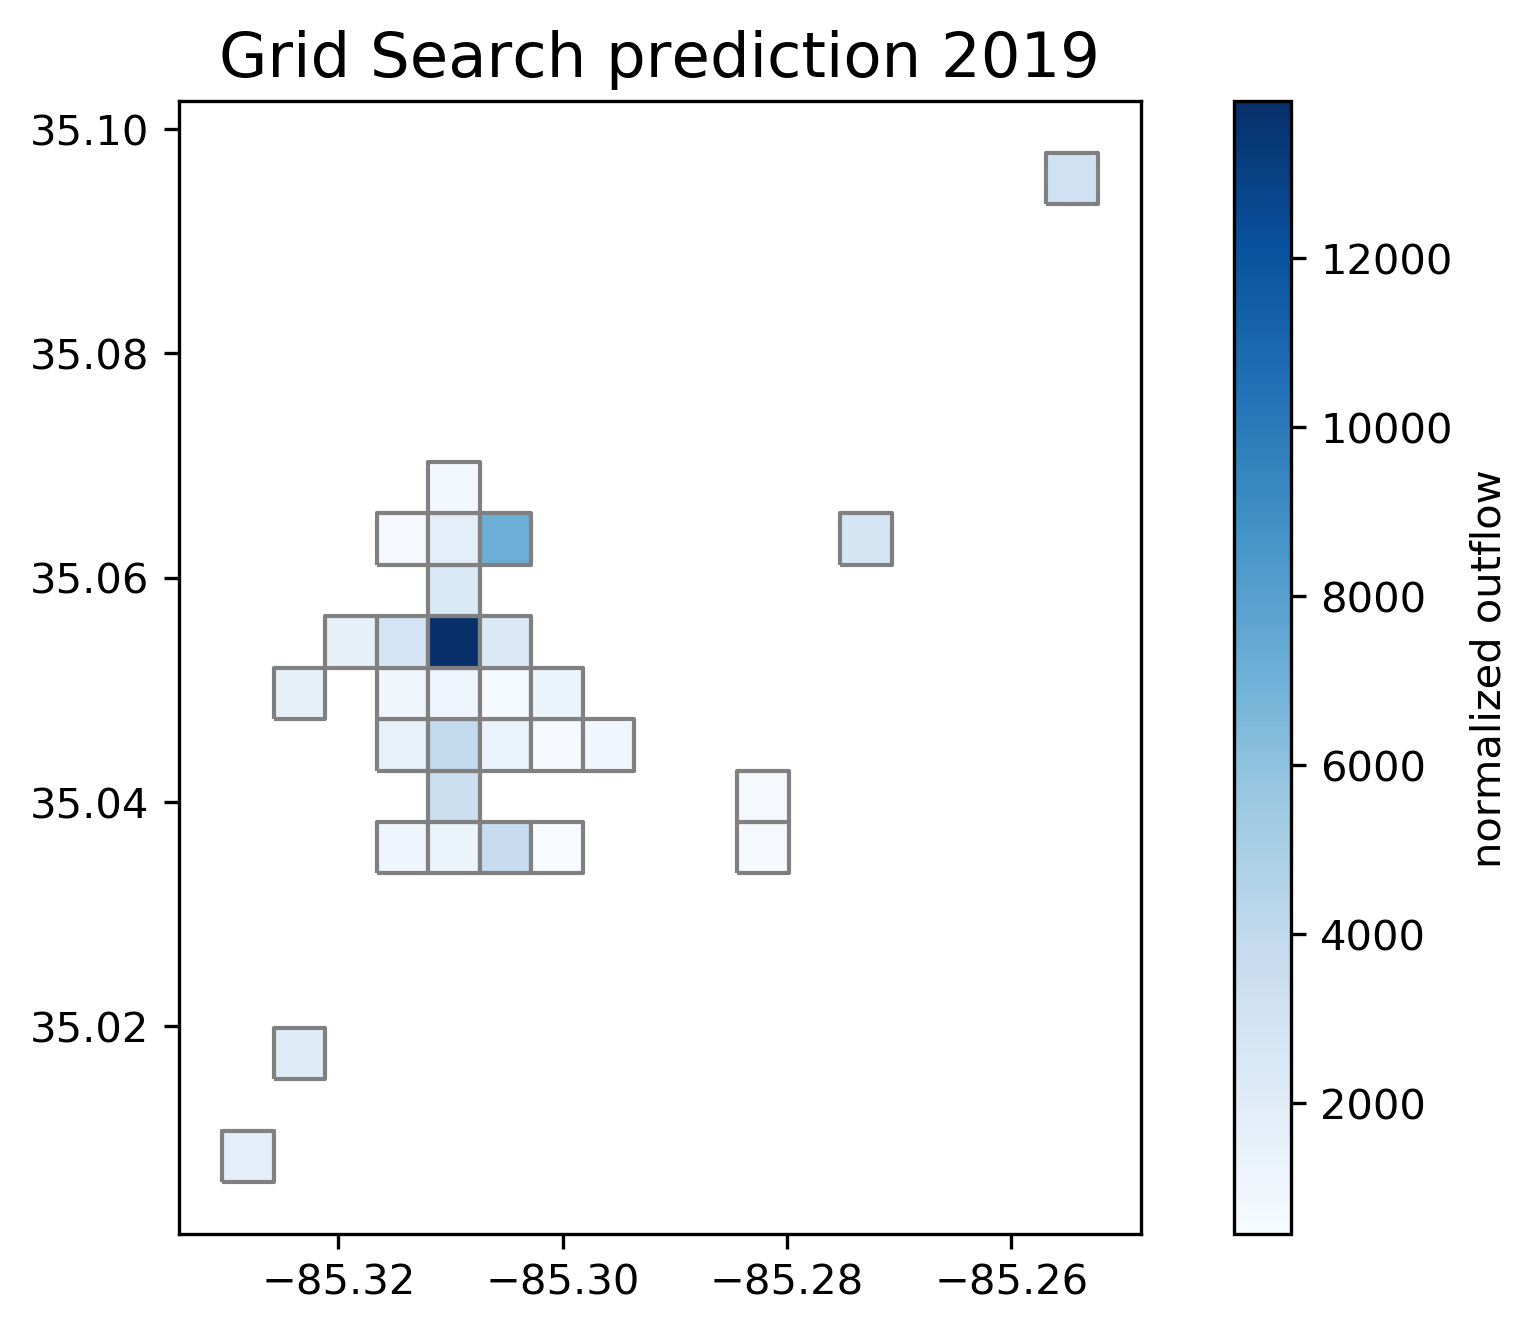

In [68]:
mitigated_gs_df = pd.DataFrame({
    # "index": y_test.index,
    "cell_num": df_19.cell_num.values,
    "y_pred": y_pred_gs,
    "y_true": y_test})
mitigated_gs_df = mitigated_gs_df.groupby("cell_num").sum()
mitigated_gs_df_plot = mitigated_gs_df.merge(df_geo, how='left', on = 'cell_num')
geo_cells_mitigated_gs = gpd.GeoDataFrame(mitigated_gs_df_plot, crs='EPSG:2956', geometry='geometry')

geo_cells_mitigated_gs.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "normalized outflow",'orientation': "vertical"})
plt.title("Grid Search prediction 2019", fontsize = 15)

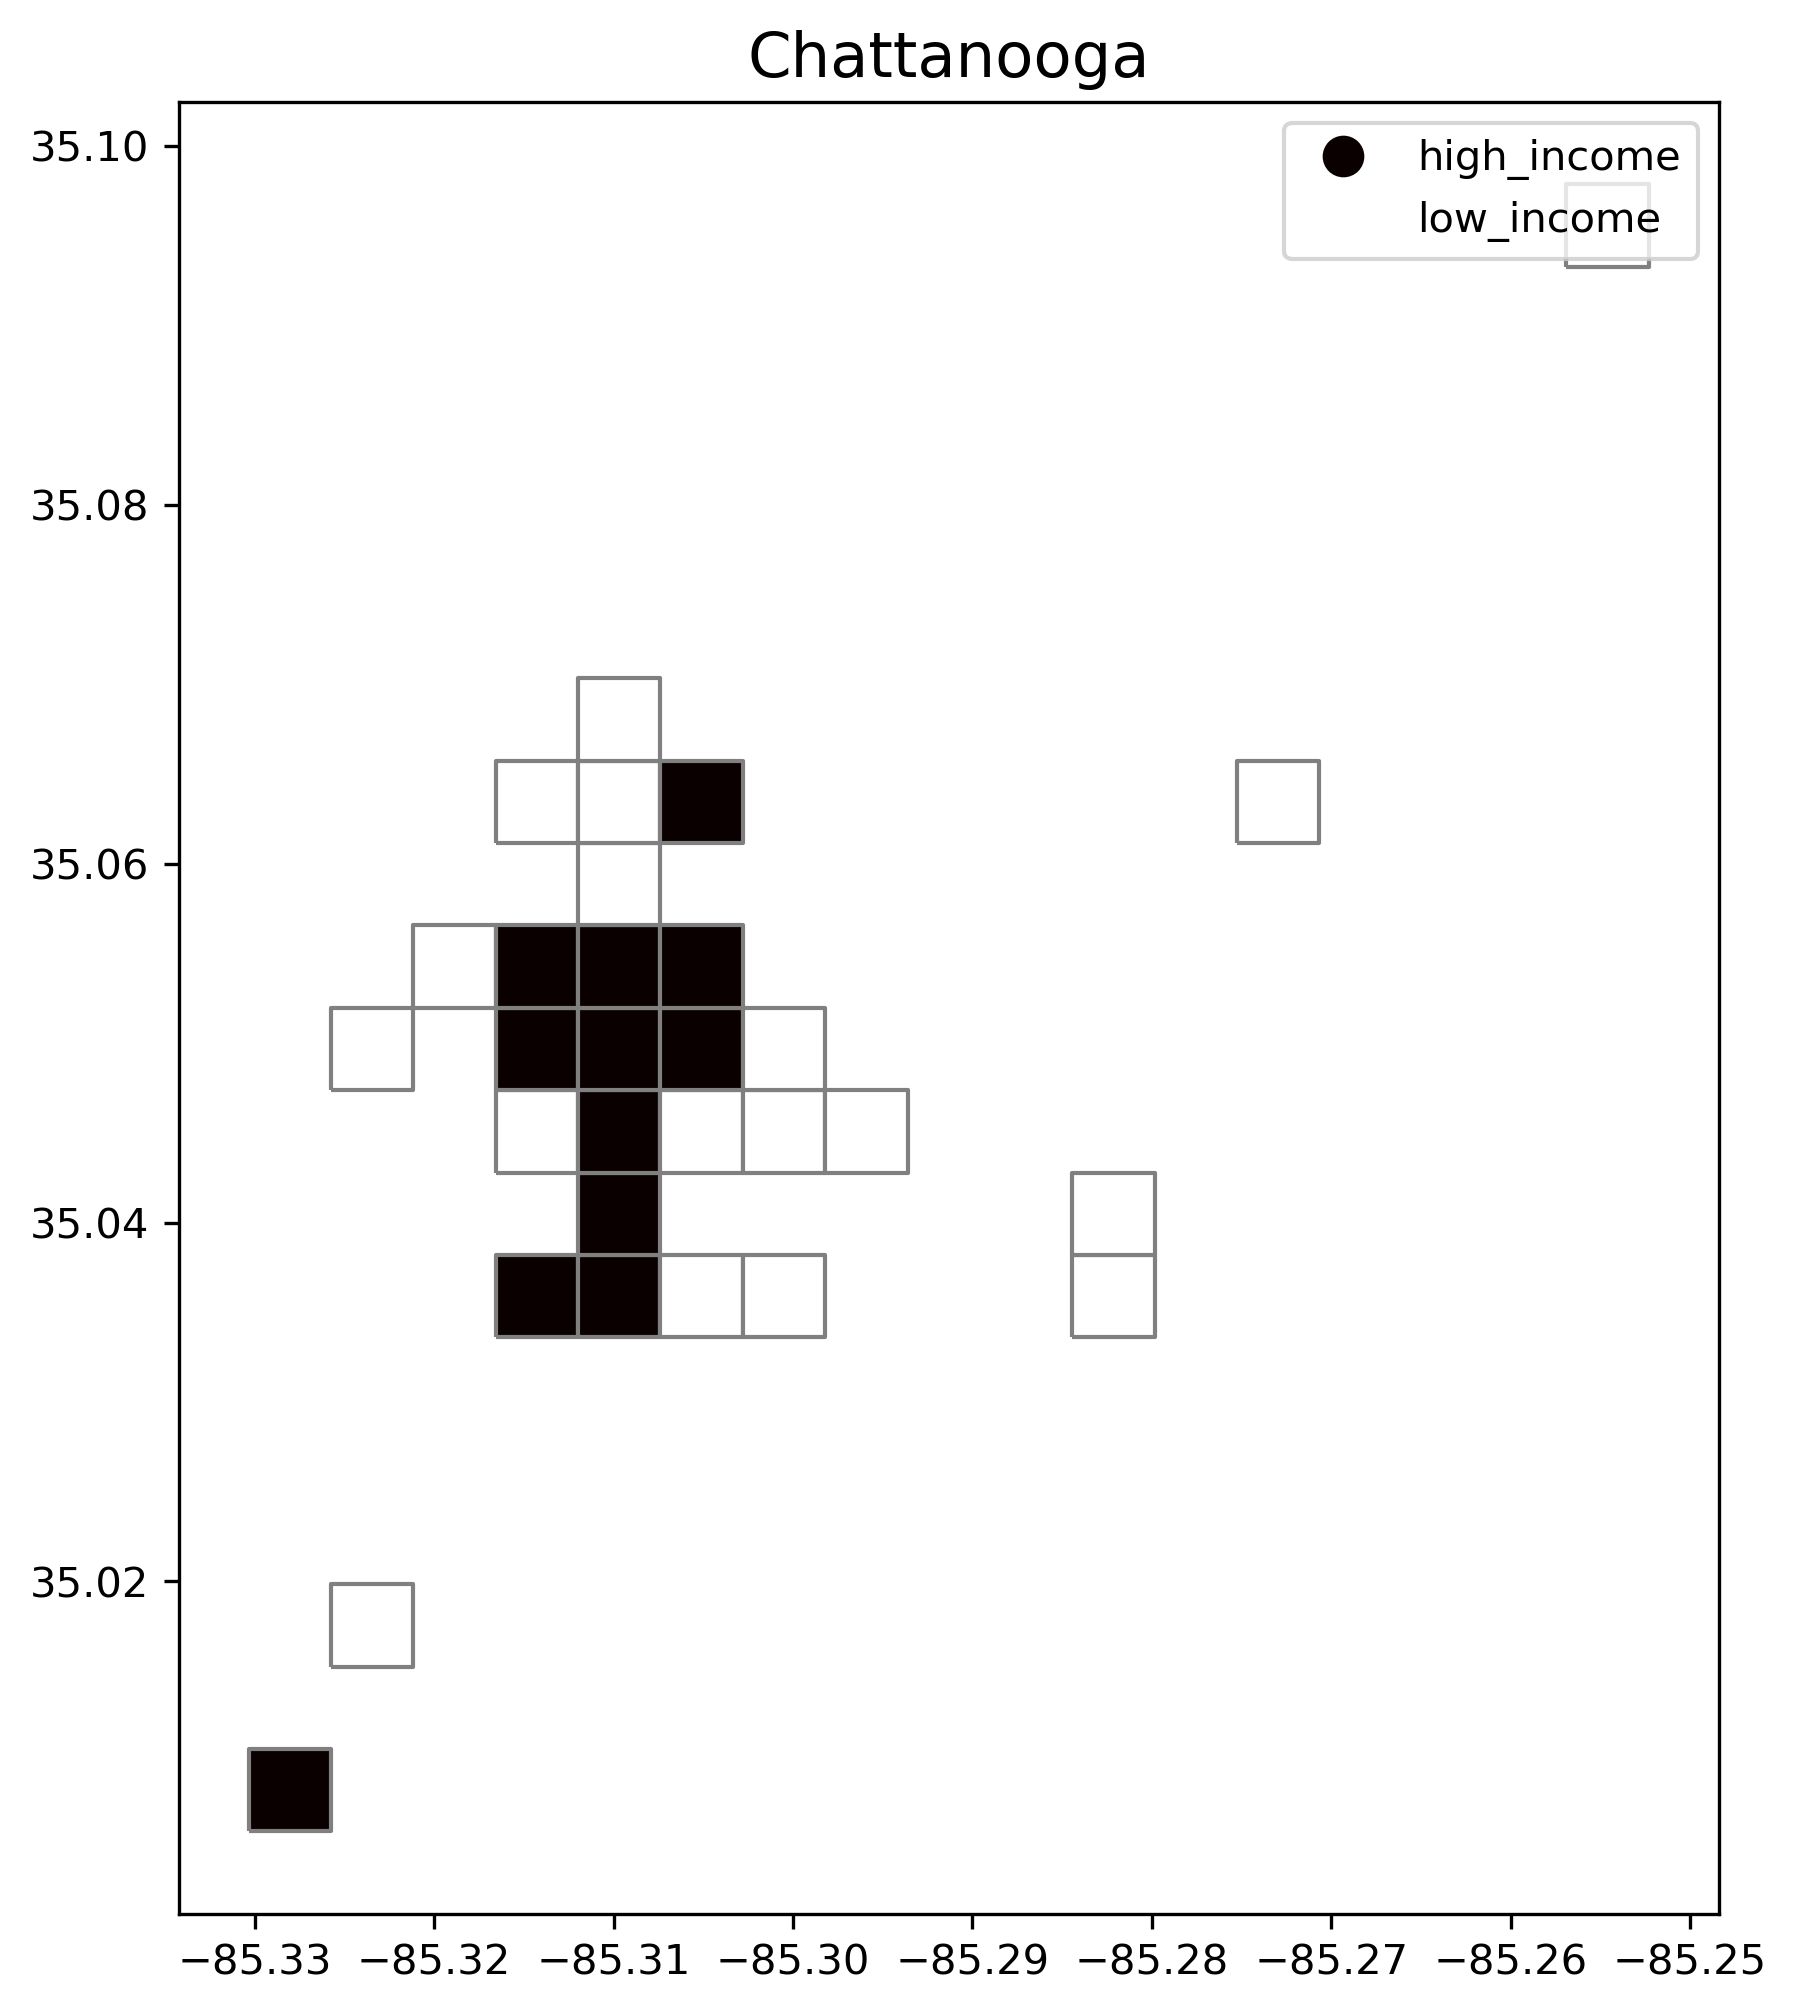

In [69]:
income_df = pd.DataFrame({"cell_num": df_19.cell_num.values,
                            "income": df_19.income_group.values})
income_df = income_df.groupby("cell_num").sum()
income_df_plot = income_df.merge(df_geo, how='left', on = 'cell_num')
geo_cells_income = gpd.GeoDataFrame(income_df_plot, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])
geo_cells_income["bi_income"] = geo_cells_income["income"].apply(lambda x: "high_income" if x > 0 else "low_income")
geo_cells_income.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(10, 8),  
                    legend = True, categorical = True)
plt.title("Chattanooga", fontsize = 15)
plt.savefig("chatt_income")

In [70]:
income_df_plot.bi_income.describe()

count             30
unique             2
top       low_income
freq              18
Name: bi_income, dtype: object

### fairST

In [1]:
fairst_pred = pd.read_csv(os.path.join(save_dir_fairst, "fairst_pred.csv"), index_col = 0)

In [66]:
for row, col in fairst_pred.iterrows():
    fairst_pred.at[row, 'geometry'] = shapely.wkt.loads(fairst_pred.loc[row]['geometry'])

Text(0.5, 1, 'fairST(lambda: 0.1) prediction in 2019')

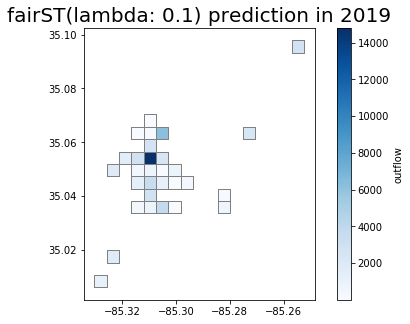

In [67]:
fairst_pred = gpd.GeoDataFrame(fairst_pred, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])

fairst_pred.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(8, 5),  
                    legend = True, legend_kwds={'label': "outflow", 'orientation': "vertical"})
plt.title("fairST(lambda: {}) prediction in 2019".format(str(0.1)), fontsize=20)

## View all

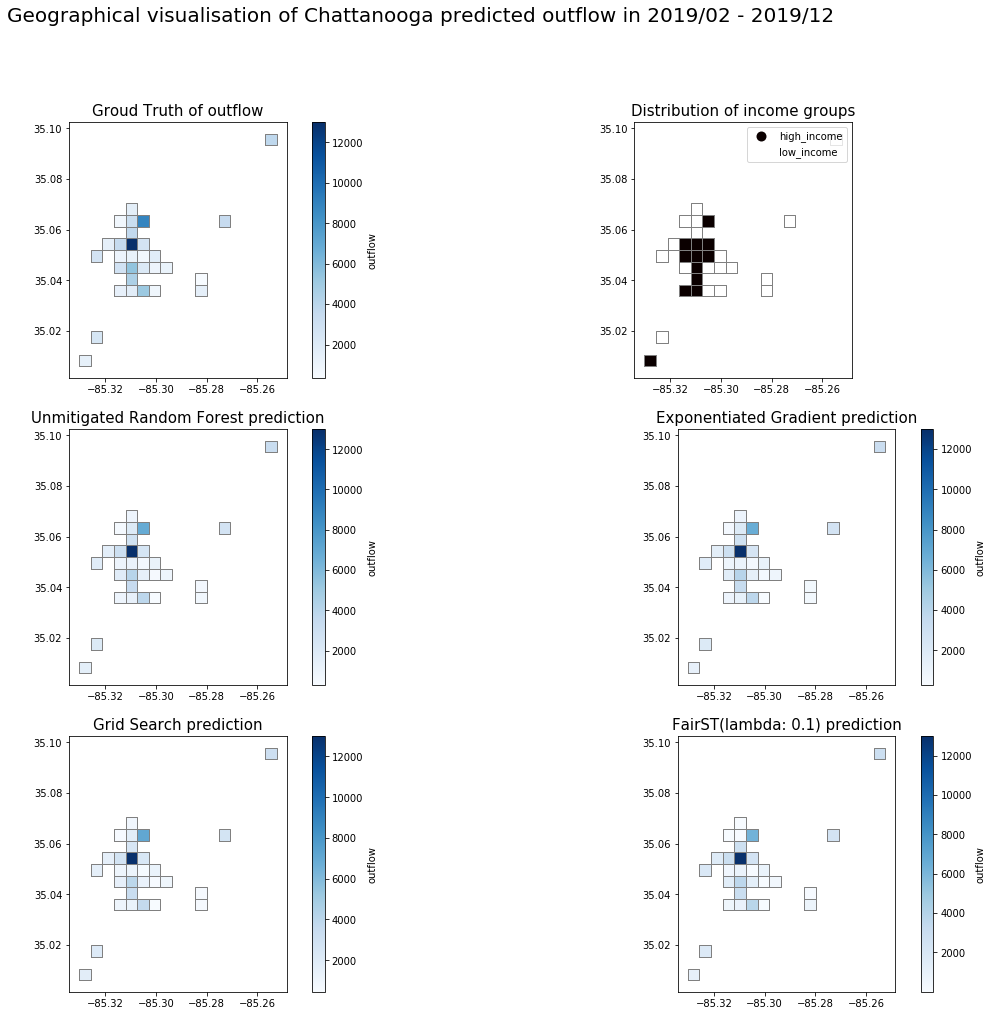

In [68]:
fig, axes = plt.subplots(3,2, figsize = (20, 16))

ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[1,0]
ax4=axes[1,1]
ax5=axes[2,0]
ax6=axes[2,1]

geo_cells_unmitigated.plot(column="y_true", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax1, vmax = 13000)
ax1.set_title("Groud Truth of outflow", size = 15)

geo_cells_income.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(5, 3), legend = True, categorical = True, ax = ax2)
ax2.set_title("Distribution of income groups", size = 15)

geo_cells_unmitigated.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax3, vmax = 13000)
ax3.set_title("Unmitigated Random Forest prediction", size = 15)

geo_cells_mitigated_eg.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax4, vmax = 13000)
ax4.set_title("Exponentiated Gradient prediction", size = 15)

geo_cells_mitigated_gs.plot(column="y_pred", cmap='Blues',edgecolor = "grey", figsize=(8,5), legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = ax5, vmax = 13000)
ax5.set_title("Grid Search prediction", size = 15)

fairst_pred.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(8, 5), legend = True, legend_kwds={'label': "outflow", 'orientation': "vertical"}, ax = ax6, vmax = 13000)
ax6.set_title("FairST(lambda: {}) prediction".format(str(0.1)), size = 15)

fig.suptitle('Geographical visualisation of Chattanooga predicted outflow in 2019/02 - 2019/12', fontsize = 20)

plt.savefig(os.path.join(save_dir_models, CITY + "geographical_visualization"))
